## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load

In [2]:
# Load the dataset
print("Loading Mars dataset...")
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

# Add a channel
X_train_val = X_train[..., np.newaxis]
y_train_val = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] 
X_test = X_test / 255.0

print("Dataset loaded!")

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Loading Mars dataset...
Dataset loaded!

Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128, 1)
Shape of y_train: (2615, 64, 128, 1)
Shape of X_test: (10022, 64, 128, 1)


## 👽 Detect Outliers

In [3]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


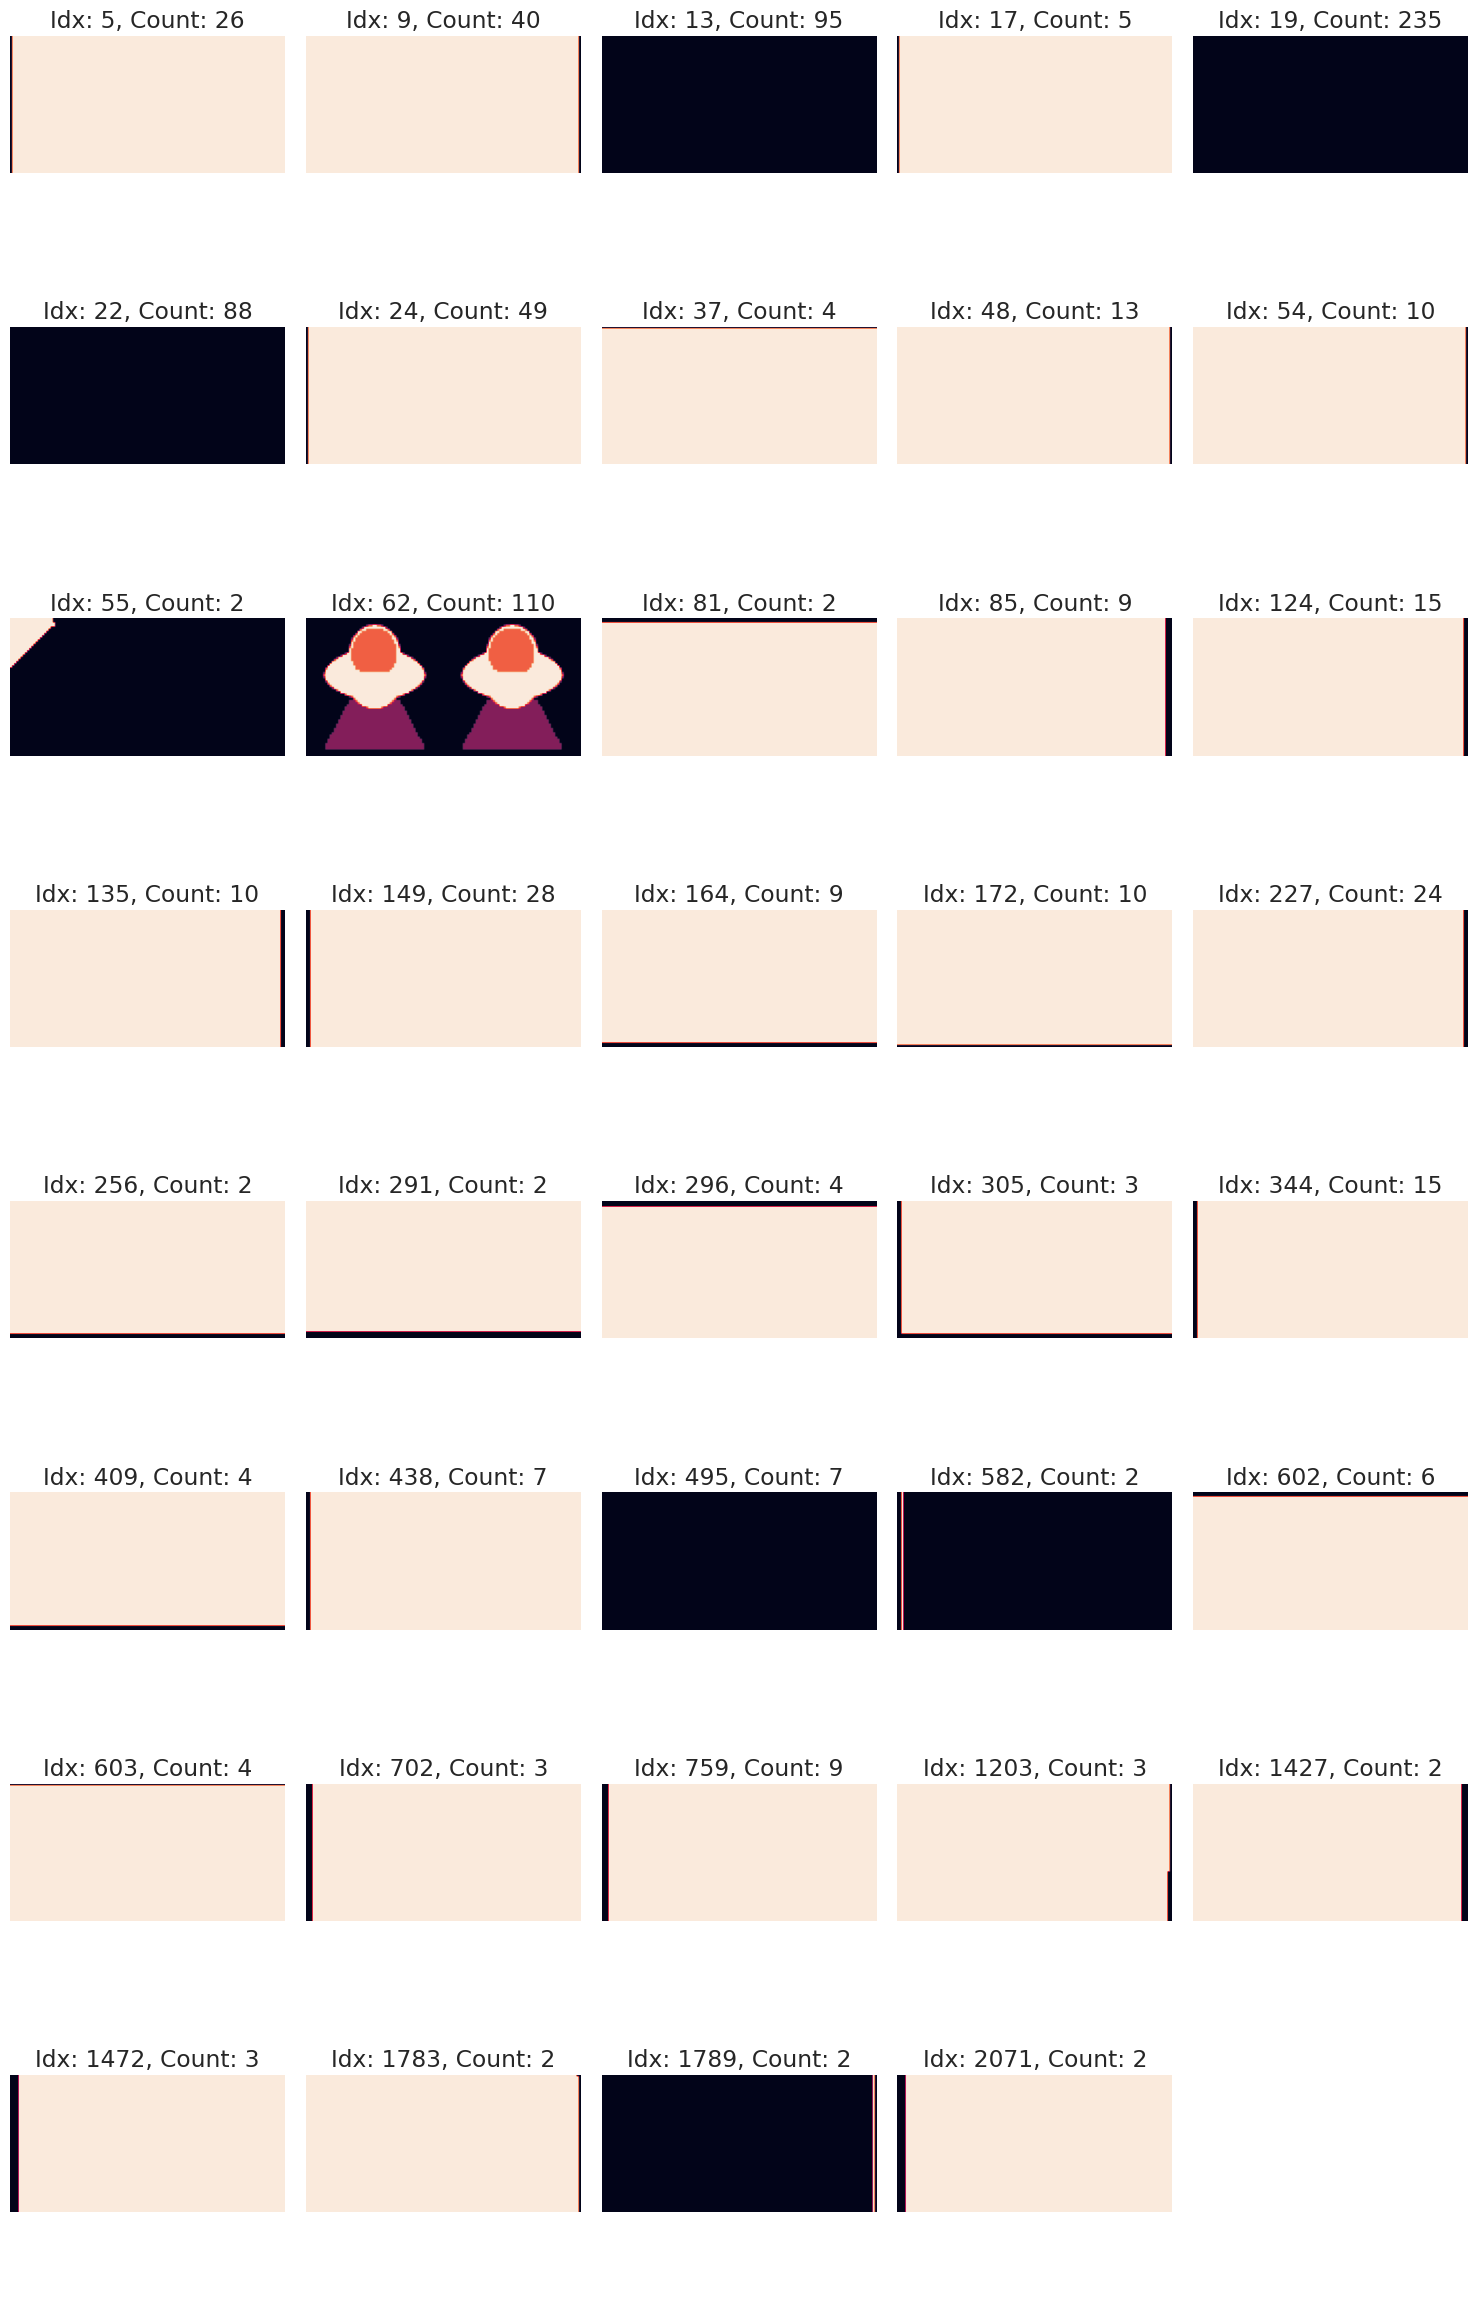

In [4]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [5]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [6]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


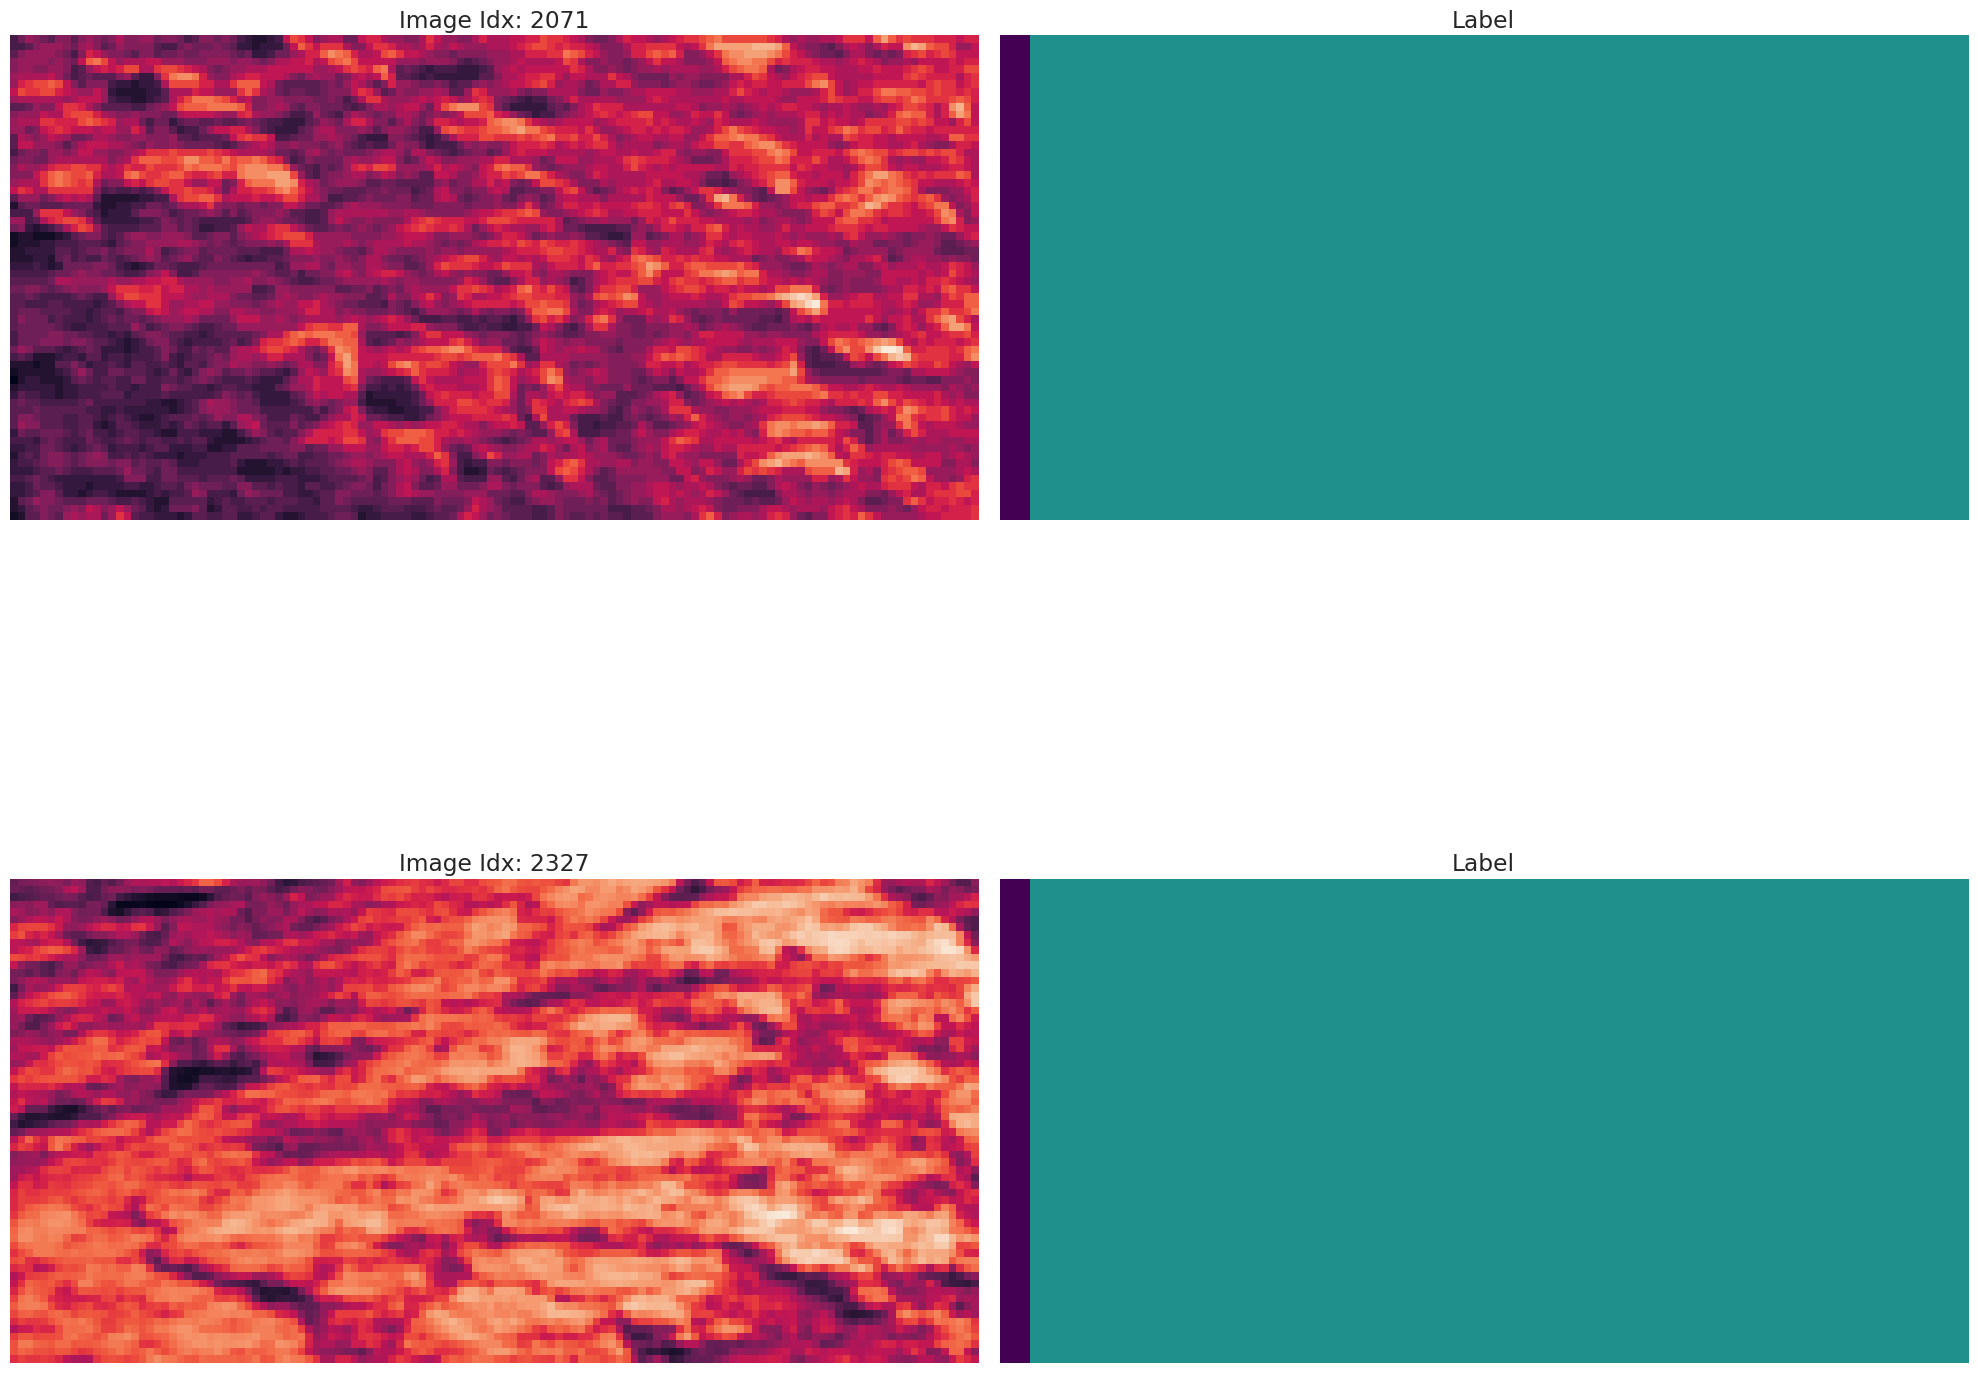

In [7]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [8]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128, 1)


## Adjust labels

In [9]:
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


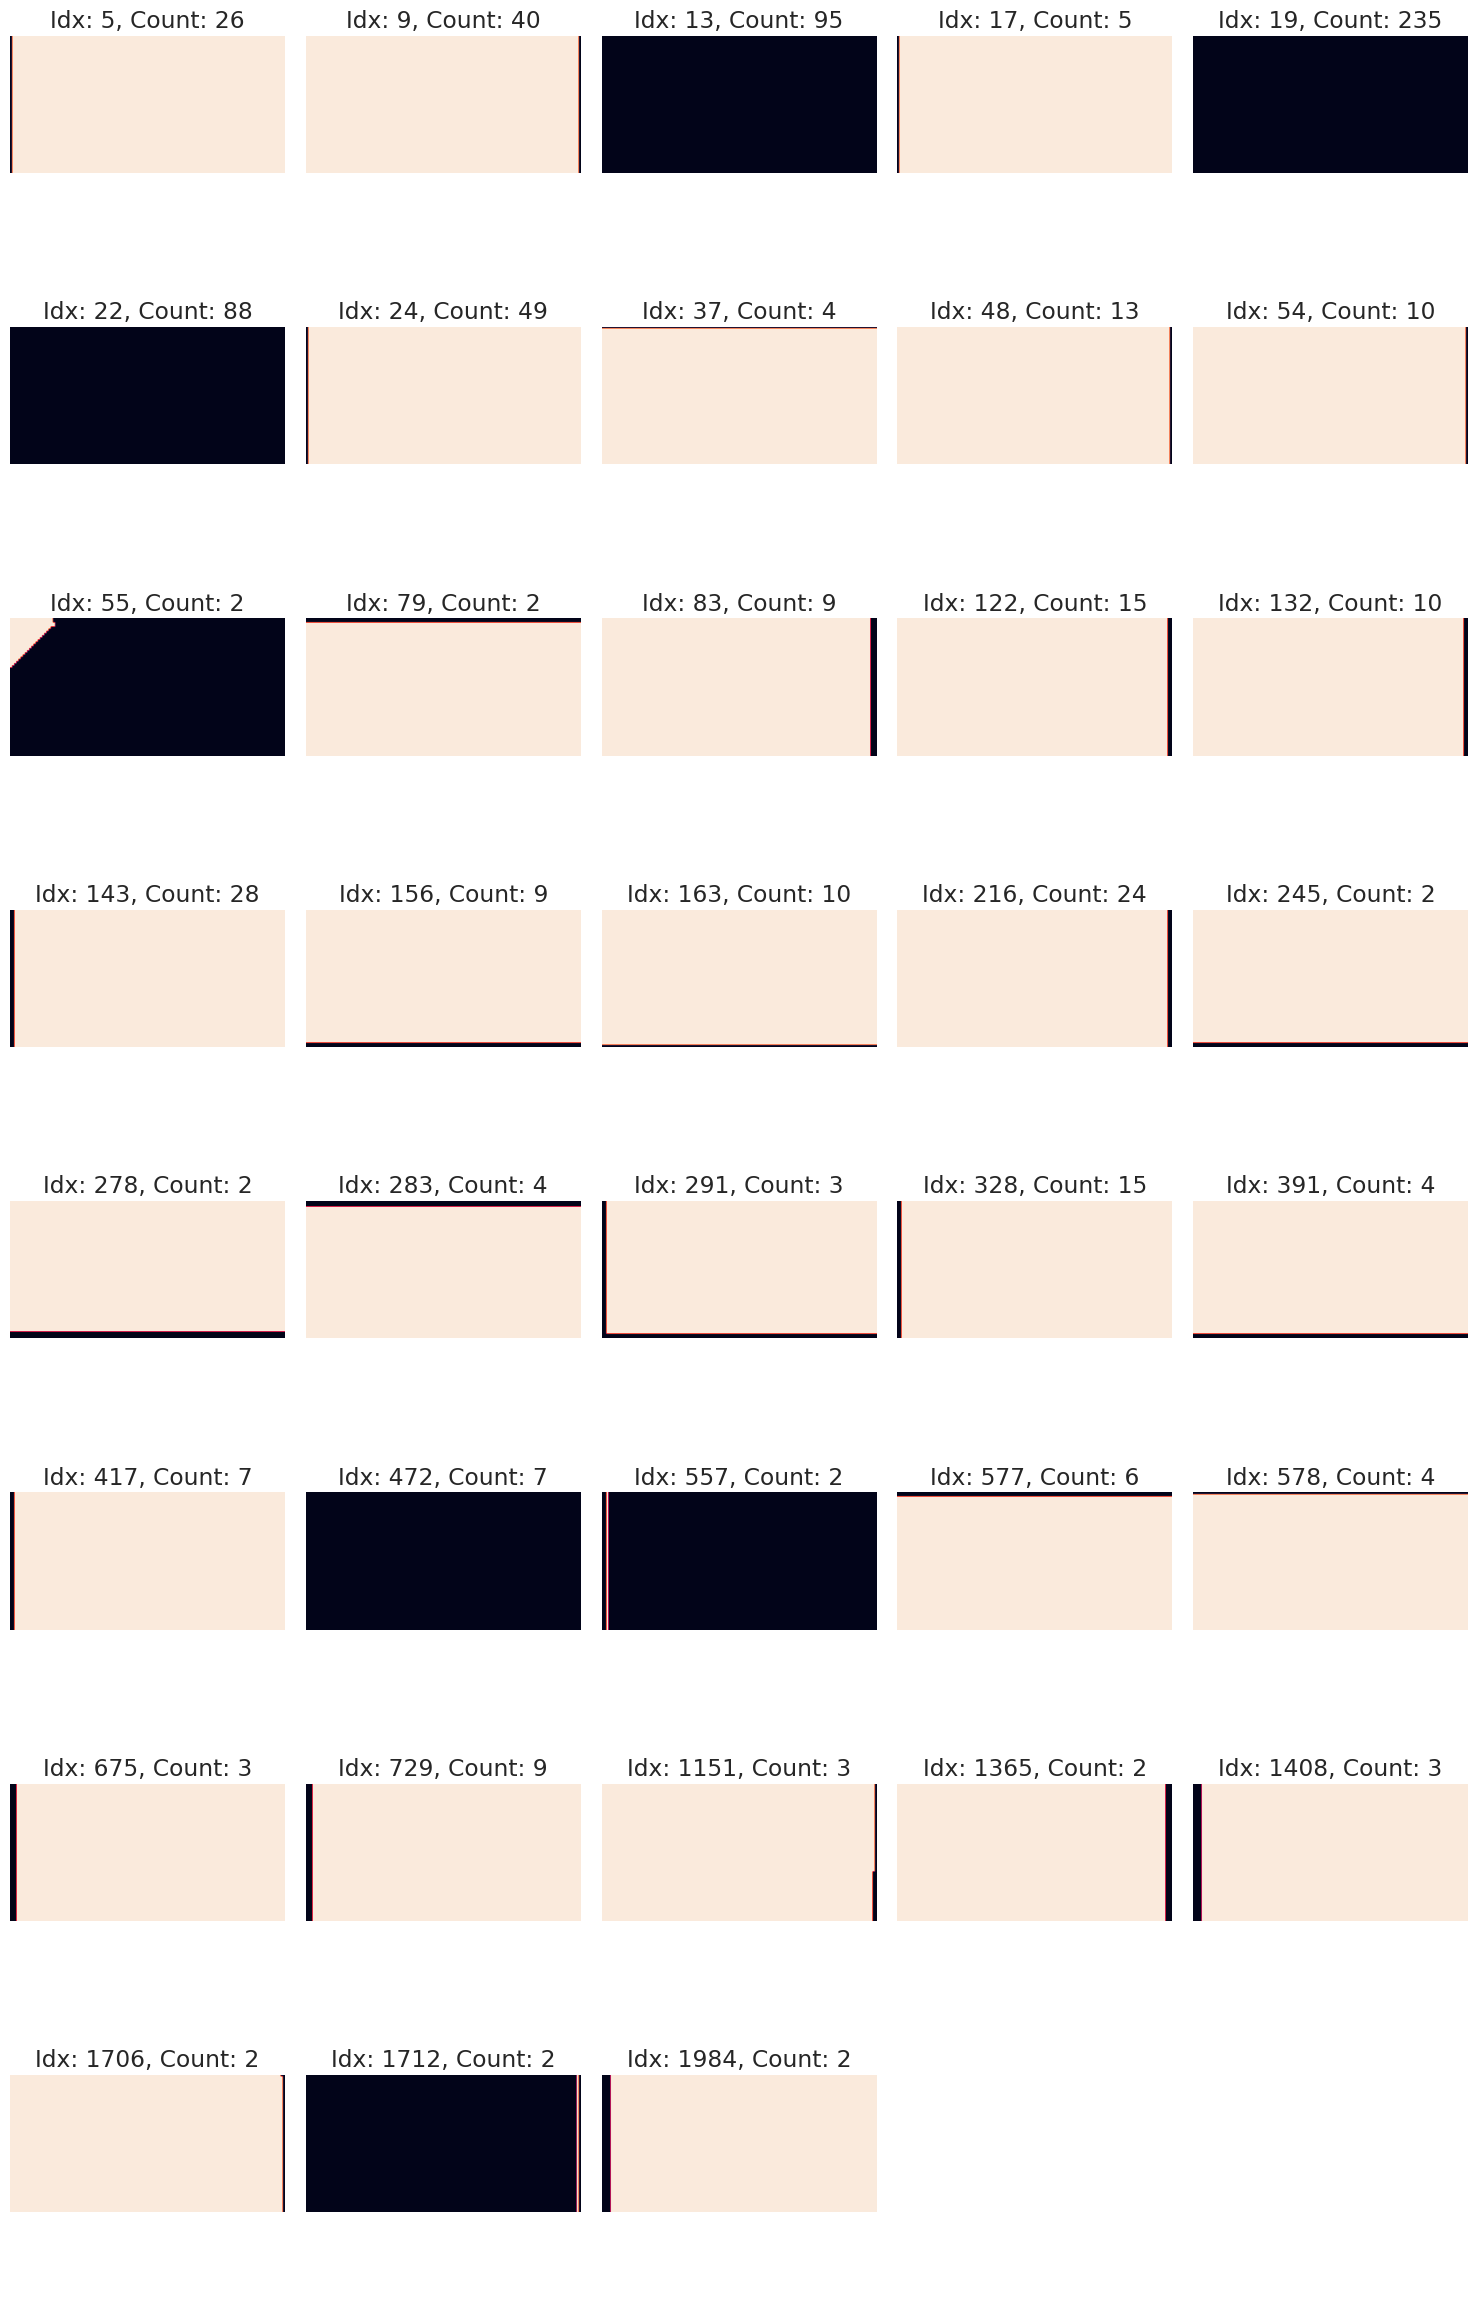

In [10]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

Hash for image at index 55: b740b976f8159c12b8e98d4c23e4b4a7


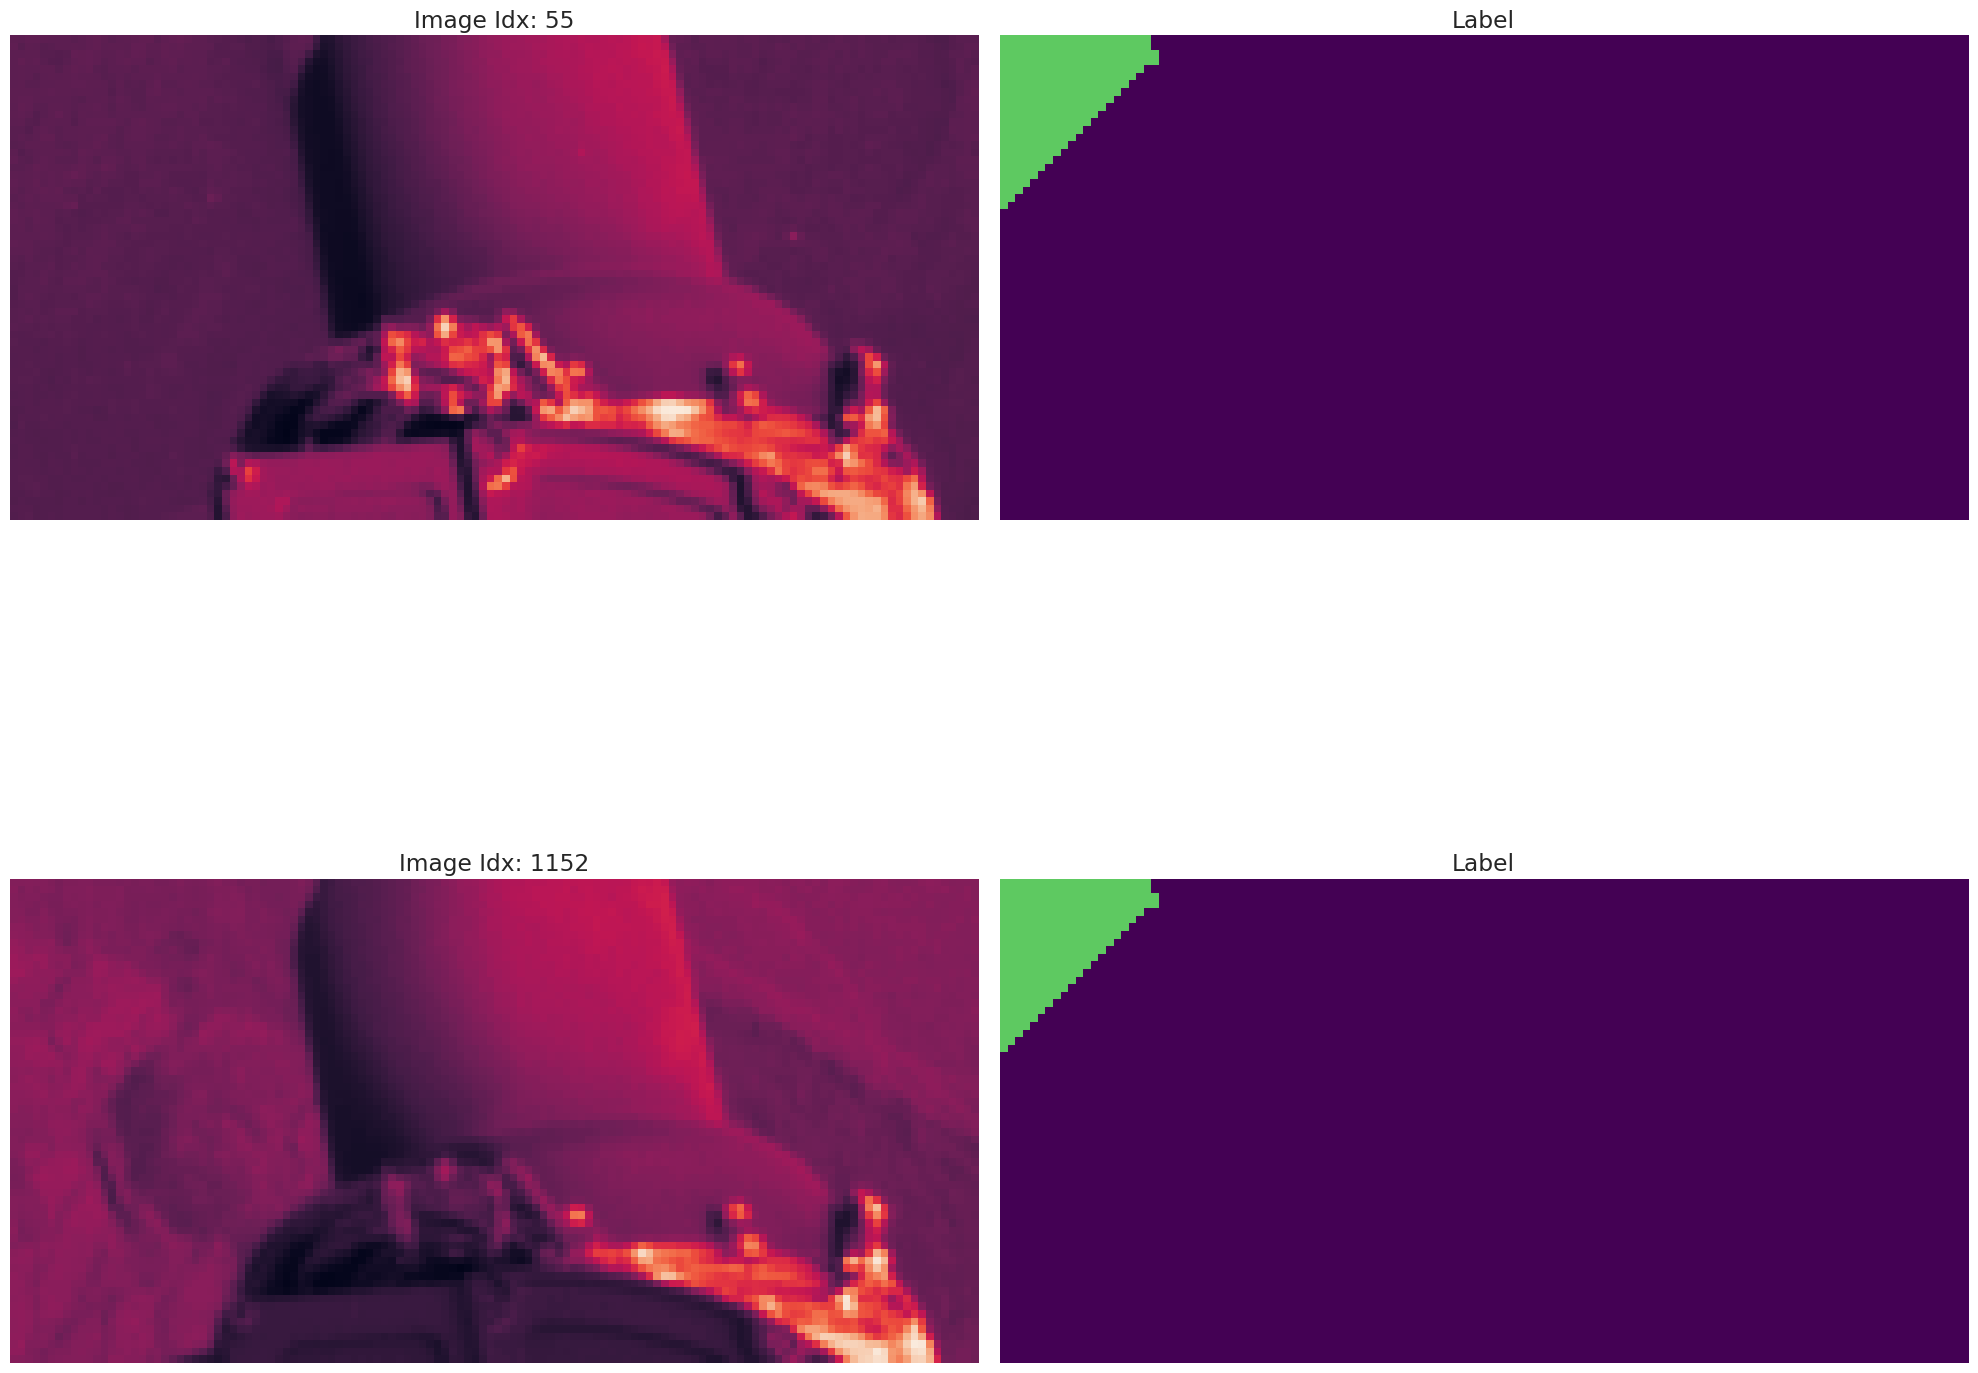

In [11]:
index_of_interest = 55

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [12]:
# Step 1: Iterate through each element in the duplicates dictionary
for key, indices in duplicates.items():

    # Step 2: For each image in the current group (indices), get the corresponding labels
    labels_to_adjust = [y_train_val[idx] for idx in indices]
    
    # Step 3: Find the most frequent label in each of the labels
    unique_values, counts = np.unique(labels_to_adjust[0], return_counts=True)
    most_frequent_label = unique_values[np.argmax(counts)]
    
    for label in labels_to_adjust:
        # Step 4: Adjust the label - replace the other values with the most frequent label
        adjusted_label = np.where(label != most_frequent_label, most_frequent_label, label)
        
    # Step 5: Replace the original label with the adjusted label
    for idx in indices:
        y_train_val[idx] = adjusted_label

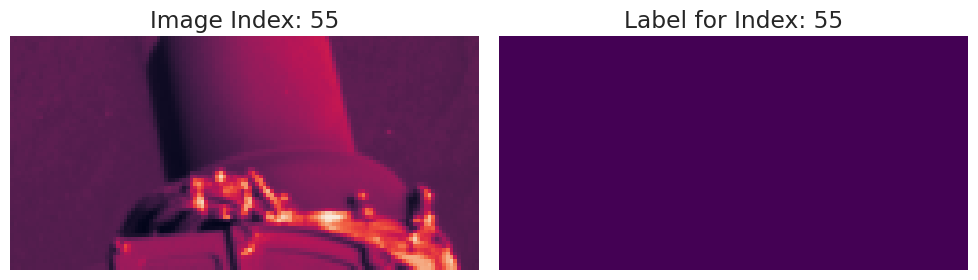

In [13]:
# Example list of indexes you want to display
indexes_to_display = [55]  # Replace with your specific indexes

# Number of images to display
num_images = len(indexes_to_display)

# Create a larger figure to accommodate multiple images and labels
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

# Loop through the selected indexes
for i, idx in enumerate(indexes_to_display):
    # Image plot
    ax_image = axes[i, 0] if num_images > 1 else axes[0]
    ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)  # Grayscale if 2D
    ax_image.set_title(f"Image Index: {idx}")
    ax_image.axis('off')

    # Label plot
    ax_label = axes[i, 1] if num_images > 1 else axes[1]
    colored_label = apply_colormap(y_train_val[idx], colormap)
    ax_label.imshow(colored_label)
    ax_label.set_title(f"Label for Index: {idx}")
    ax_label.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 🔄 Process Data

In [14]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [15]:
# Split the training set into training and validation sets
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [16]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


In [17]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0
    
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

In [18]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)



In [19]:
# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [20]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) #create data from images and masks

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed) #we can shuffle it

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [21]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False #for validation not necessary to shuffle it
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


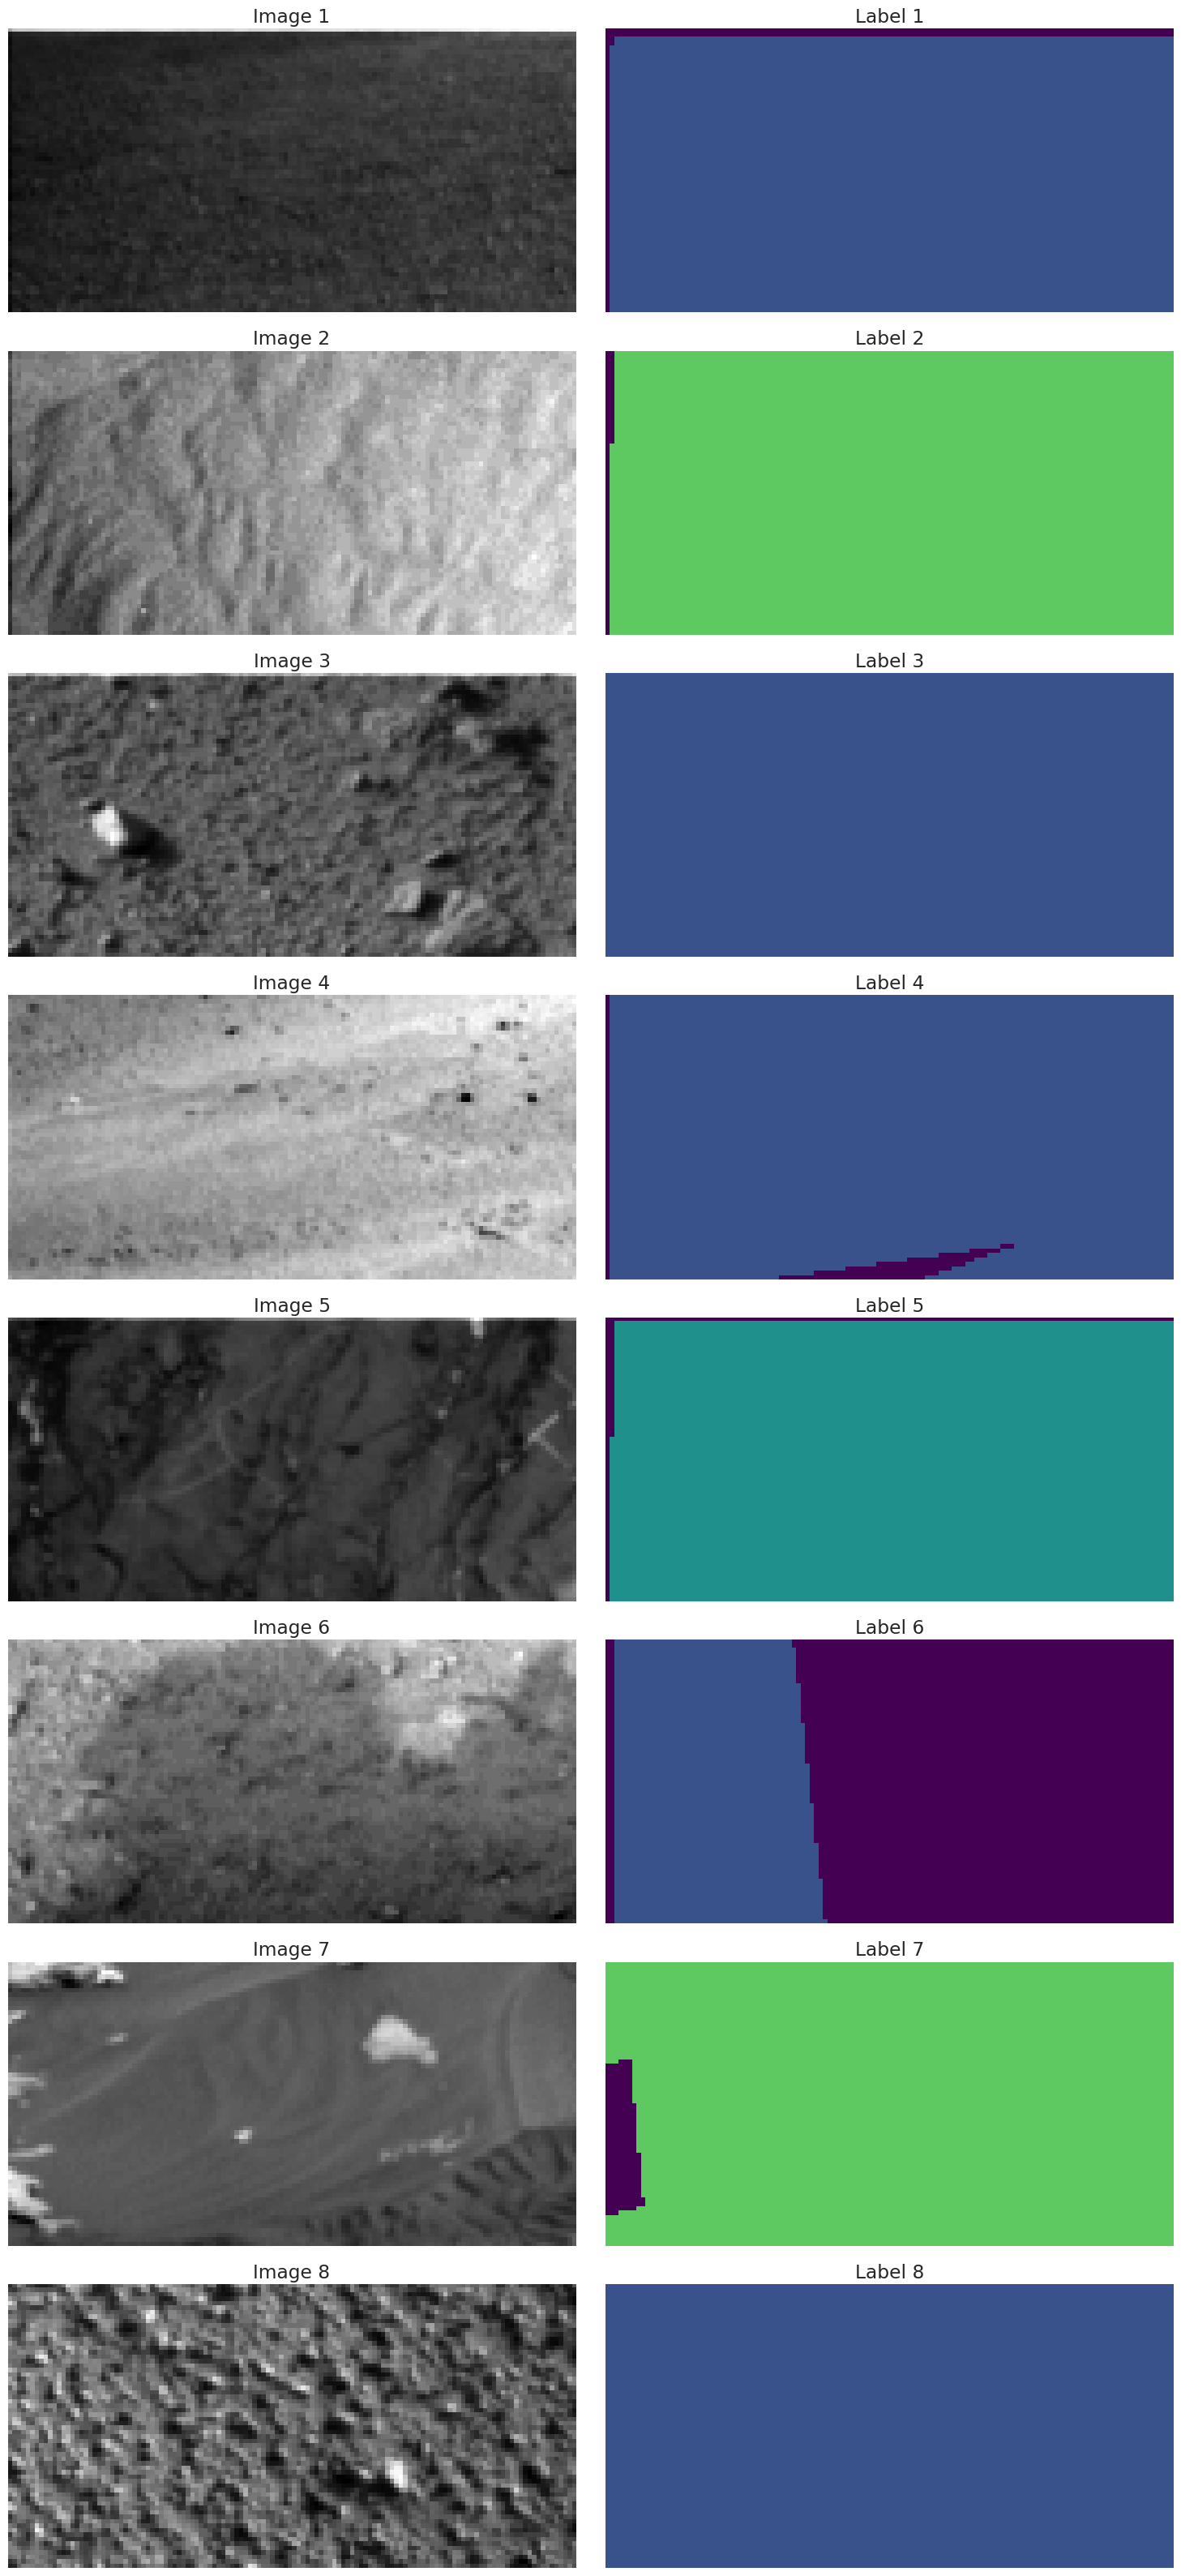

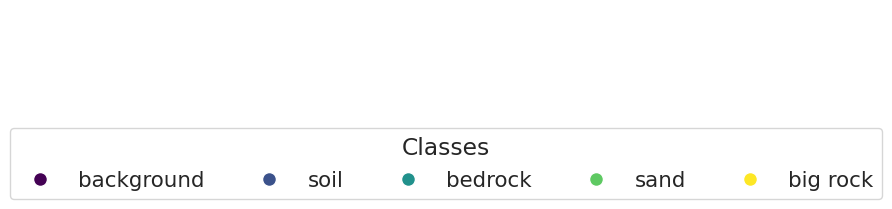

In [22]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [23]:
'''def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x'''

"def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):\n    # Initialise the input tensor\n    x = input_tensor\n\n    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks\n    for i in range(stack):\n        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)\n        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)\n        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)\n\n    # Return the transformed tensor\n    return x"

In [24]:
'''def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')  # first block with 32 filters
    d1 = tfkl.MaxPooling2D()(down_block_1)  # reduce spatial complexity

    down_block_2 = unet_block(d1, 64, name='down_block2_')  # second block with 64 filters
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # third block with 128 filters
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # fourth block with 256 filters
    d4 = tfkl.MaxPooling2D()(down_block_4)

    down_block_5 = unet_block(d4, 512, name='down_block5_')  # added downsampling block with 512 filters
    d5 = tfkl.MaxPooling2D()(down_block_5)

    # Bottleneck with 1024 filters
    bottleneck = unet_block(d5, 1024, name='bottleneck')  # bottleneck with 1024 filters

    # Upsampling path: increase spatial complexity
    u1 = tfkl.UpSampling2D()(bottleneck)  # Upsampling
    u1 = tfkl.Concatenate()([u1, down_block_5])  # Skip connection from downsampling path
    u1 = unet_block(u1, 512, name='up_block1_')  # Upsampling block with 512 filters

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_4])
    u2 = unet_block(u2, 256, name='up_block2_')  # second upsampling block with 256 filters

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 128, name='up_block3_')  # third upsampling block with 128 filters

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_2])
    u4 = unet_block(u4, 64, name='up_block4_')  # fourth upsampling block with 64 filters

    u5 = tfkl.UpSampling2D()(u4)
    u5 = tfkl.Concatenate()([u5, down_block_1])
    u5 = unet_block(u5, 32, name='up_block5_')  # fifth upsampling block with 32 filters

    # Output Layer: final convolution with softmax activation for segmentation
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u5)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model'''

'def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):\n    tf.random.set_seed(seed)\n    input_layer = tfkl.Input(shape=input_shape, name=\'input_layer\')\n\n    # Downsampling path\n    down_block_1 = unet_block(input_layer, 32, name=\'down_block1_\')  # first block with 32 filters\n    d1 = tfkl.MaxPooling2D()(down_block_1)  # reduce spatial complexity\n\n    down_block_2 = unet_block(d1, 64, name=\'down_block2_\')  # second block with 64 filters\n    d2 = tfkl.MaxPooling2D()(down_block_2)\n\n    down_block_3 = unet_block(d2, 128, name=\'down_block3_\')  # third block with 128 filters\n    d3 = tfkl.MaxPooling2D()(down_block_3)\n\n    down_block_4 = unet_block(d3, 256, name=\'down_block4_\')  # fourth block with 256 filters\n    d4 = tfkl.MaxPooling2D()(down_block_4)\n\n    down_block_5 = unet_block(d4, 512, name=\'down_block5_\')  # added downsampling block with 512 filters\n    d5 = tfkl.MaxPooling2D()(down_block_5)\n\n    # Bottleneck with 1024 filters

In [25]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
	# Applying the sequence of Convolutional, Batch Normalization
	# and Activation Layers to the input tensor
	x = tf.keras.Sequential([
		# Convolutional Layer
		tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
		# Batch Normalization Layer
		tf.keras.layers.BatchNormalization(),
		# Activation Layer
		tf.keras.layers.Activation('relu'),
		# Convolutional Layer
		tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
		# Batch Normalization Layer
		tf.keras.layers.BatchNormalization(),
		# Activation Layer
		tf.keras.layers.Activation('relu')
	])(inputs)

	# Returning the output of the Convolutional Block
	return x


# Defining the Unet++ Model
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, deep_supervision = False):
	inputs = tf.keras.layers.Input(shape=input_shape)

	# Encoding Path
	x_00 = conv_block(inputs, 64)
	x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 128)
	x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 256)
	x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 512)
	x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 1024)

	# Nested Decoding Path
	x_01 = conv_block(tf.keras.layers.concatenate(
		[x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
	x_11 = conv_block(tf.keras.layers.concatenate(
		[x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
	x_21 = conv_block(tf.keras.layers.concatenate(
		[x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
	x_31 = conv_block(tf.keras.layers.concatenate(
		[x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)

	x_02 = conv_block(tf.keras.layers.concatenate(
		[x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 64)
	x_12 = conv_block(tf.keras.layers.concatenate(
		[x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
	x_22 = conv_block(tf.keras.layers.concatenate(
		[x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)

	x_03 = conv_block(tf.keras.layers.concatenate(
		[x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 64)
	x_13 = conv_block(tf.keras.layers.concatenate(
		[x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 128)

	x_04 = conv_block(tf.keras.layers.concatenate(
		[x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 64)

	# Deep Supervision Path
	# If deep supervision is enabled, then the model will output the segmentation maps
	# at each stage of the decoding path
	if deep_supervision:
		outputs = [
			tf.keras.layers.Conv2D(num_classes, 1)(x_01),
			tf.keras.layers.Conv2D(num_classes, 1)(x_02),
			tf.keras.layers.Conv2D(num_classes, 1)(x_03),
			tf.keras.layers.Conv2D(num_classes, 1)(x_04)
		]
		# Concatenating the segmentation maps
		outputs = tf.keras.layers.concatenate(outputs, axis=0)

	# If deep supervision is disabled, then the model will output the final segmentation map
	# which is the segmentation map at the end of the decoding path
	else:
		outputs = tf.keras.layers.Conv2D(num_classes, 1)(x_04)

	# Creating the model
	model = tf.keras.Model(
		inputs=inputs, outputs=outputs, name='Unet')

	# Returning the model
	return model

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential        │ (None, 64, 128, │    38,080 │ input_layer[0… │   Y   │
│ (Sequential)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ sequential[0]… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_1      │ (None, 32, 64,  │   222,464 │ max_pooling2d… │   Y   │
│ (Sequential)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ sequential_1[… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_2      │ (None, 16, 32,  │   887,296 │ max_pooling2d… │   Y   │
│ (Sequential)      │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_2   │ (None, 8, 16,   │         0 │ sequential_2[… │   -   │
│ (MaxPooling2D)    │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_3      │ (None, 8, 16,   │ 3,544,064 │ max_pooling2d… │   Y   │
│ (Sequential)      │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_3   │ (None, 4, 8,    │         0 │ sequential_3[… │   -   │
│ (MaxPooling2D)    │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_4      │ (None, 4, 8,    │ 14,166,0… │ max_pooling2d… │   Y   │
│ (Sequential)      │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ up_sampling2d_3   │ (None, 8, 16,   │         0 │ sequential_4[… │   -   │
│ (UpSampling2D)    │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ up_sampling2d_2   │ (None, 16, 32,  │         0 │ sequential_3[… │   -   │
│ (UpSampling2D)    │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_3     │ (None, 8, 16,   │         0 │ sequential_3[… │   -   │
│ (Concatenate)     │ 1536)           │           │ up_sampling2d… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ up_sampling2d_1   │ (None, 32, 64,  │         0 │ sequential_2[… │   -   │
│ (UpSampling2D)    │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_2     │ (None, 16, 32,  │         0 │ sequential_2[… │   -   │
│ (Concatenate)     │ 768)            │           │ up_sampling2d… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_8      │ (None, 8, 16,   │ 9,442,304 │ concatenate_3… │   Y   │
│ (Sequential)      │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ up_sampling2d     │ (None, 64, 128, │         0 │ sequential_1[… │   - 

 Total params: 36,643,333 (139.78 MB)

 Trainable params: 36,628,741 (139.73 MB)

 Non-trainable params: 14,592 (57.00 KB)

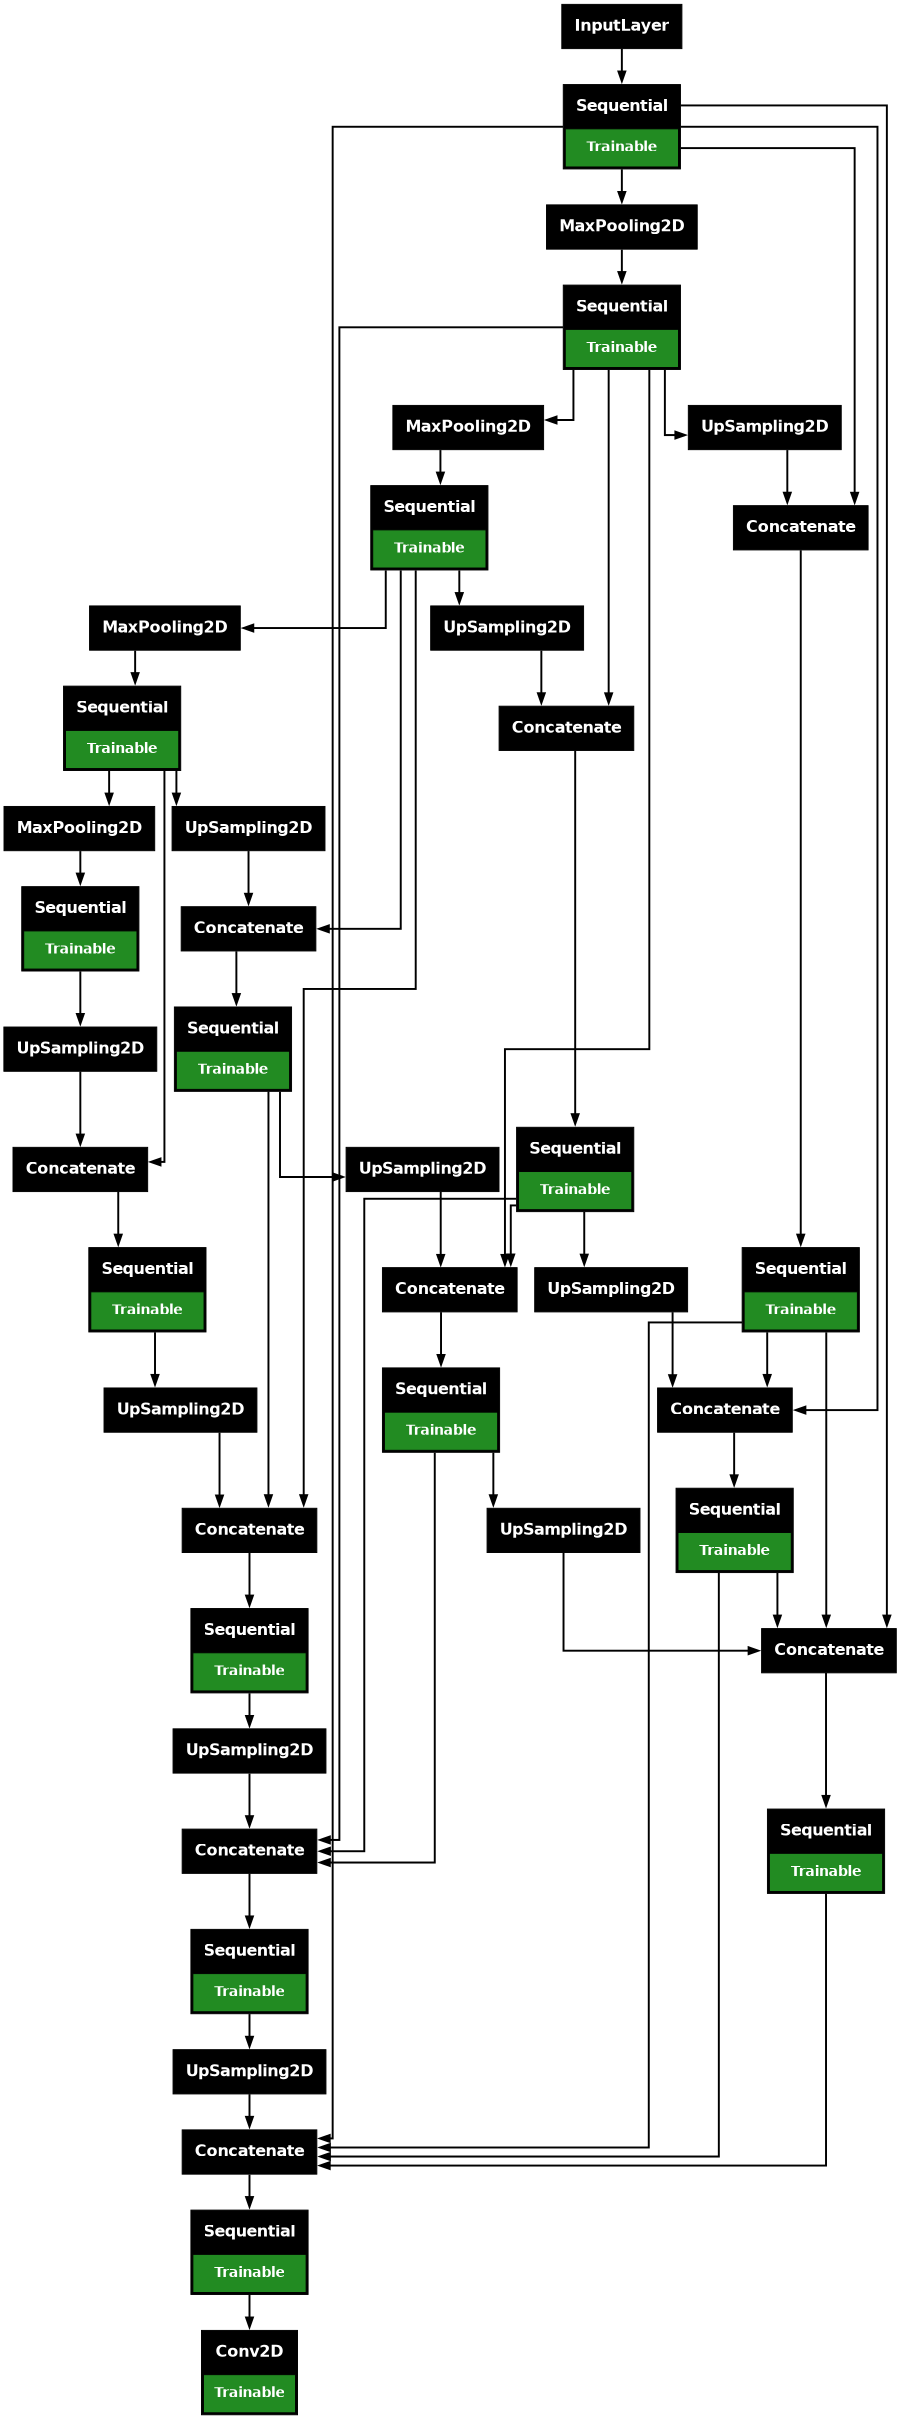

In [26]:
model = get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES,deep_supervision=False)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)

In [27]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                image = image_batch[0]  # Take the first image from the batch
                label = label_batch[0]  # Take the first label from the batch

                # Add batch dimension to the image (if necessary)
                image = tf.expand_dims(image, 0)

                # Perform prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()  # Convert to NumPy array for visualization

                # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                num_classes = NUM_CLASSES
               # colormap = create_segmentation_colormap(num_classes)

                # Plot the results
                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image[0], cmap='gray')
                plt.title("Input Image")
                plt.axis('off')

                # Ground truth
                plt.subplot(1, 3, 2)
                colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                plt.imshow(colored_label)
                plt.title("Ground Truth Mask")
                plt.axis('off')

                # Prediction
                plt.subplot(1, 3, 3)
                colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                plt.imshow(colored_pred)
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                plt.close()

In [28]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #not categorical crossentropy
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [29]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou', 
    factor=0.1, 
    patience=15, 
    min_lr=1e-5,
    mode='max'
)

viz_callback = VizCallback(val_dataset, frequency=5)

Epoch 1/1000


I0000 00:00:1733308840.337928      83 service.cc:145] XLA service 0x7fc6780033b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733308840.338009      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733308840.338017      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733308846.940295      83 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733308985.225476      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3128 - loss: 4.1745 - mean_iou: 0.1120

W0000 00:00:1733309027.313544      83 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3130 - loss: 4.1265 - mean_iou: 0.1119

W0000 00:00:1733309096.492980      83 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733309105.307937      83 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


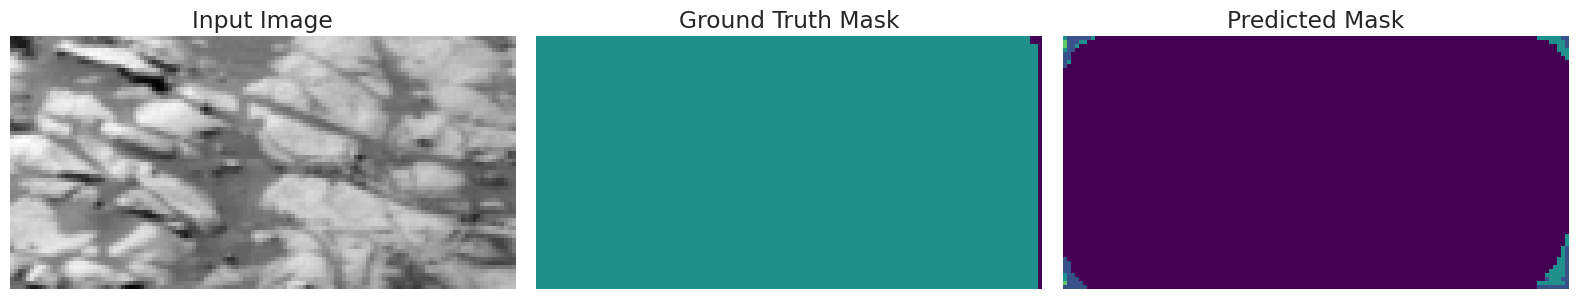

32/32 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.3133 - loss: 4.0814 - mean_iou: 0.1117 - val_accuracy: 0.2433 - val_loss: 11.7096 - val_mean_iou: 0.0029 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3464 - loss: 1.4871 - mean_iou: 0.0951 - val_accuracy: 0.2109 - val_loss: 1.4124 - val_mean_iou: 0.0658 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3293 - loss: 1.4689 - mean_iou: 0.1185 - val_accuracy: 0.2068 - val_loss: 1.4335 - val_mean_iou: 0.0610 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3172 - loss: 1.4206 - mean_iou: 0.1228 - val_accuracy: 0.3483 - val_loss: 1.4168 - val_mean_iou: 0.1152 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3306 - loss: 1.3929 - mean_iou: 0.1273 - val_accuracy: 0.3464 - val_loss: 1.4802 - val_mean_iou: 0.0830 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

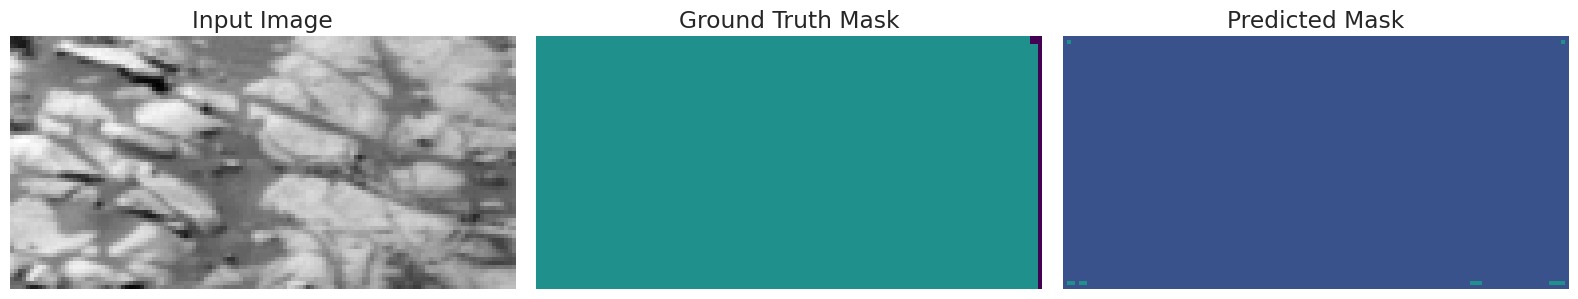

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3716 - loss: 1.4023 - mean_iou: 0.1450 - val_accuracy: 0.3463 - val_loss: 4.0016 - val_mean_iou: 0.1161 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3607 - loss: 1.4035 - mean_iou: 0.1191 - val_accuracy: 0.3429 - val_loss: 1.4015 - val_mean_iou: 0.1418 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3378 - loss: 1.3820 - mean_iou: 0.1012 - val_accuracy: 0.3419 - val_loss: 1.3797 - val_mean_iou: 0.1420 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3516 - loss: 1.3761 - mean_iou: 0.1270 - val_accuracy: 0.3104 - val_loss: 1.3910 - val_mean_iou: 0.1182 - learning_rate: 0.0010
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3660 - loss: 1.3819 - mean_iou: 0.1386 - val_accuracy: 0.3333 - val_loss: 1.3751 - val_mean_iou: 0.1365 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

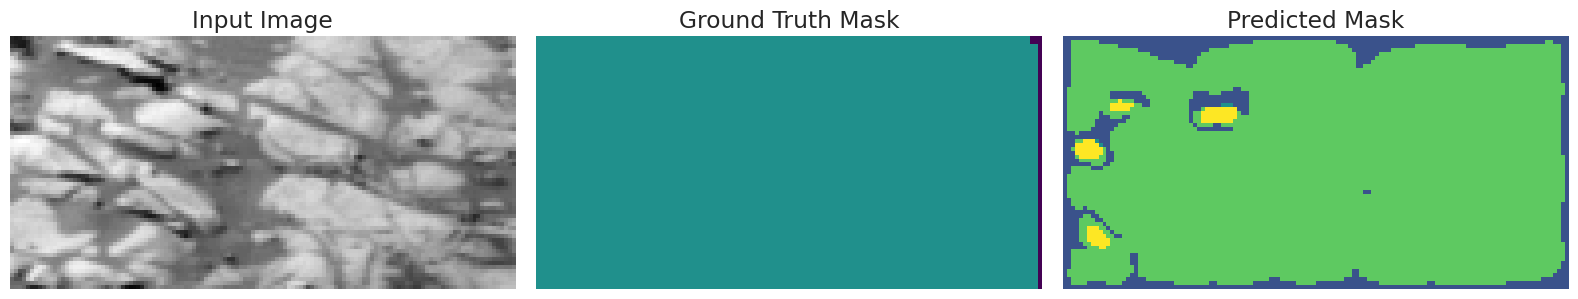

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3792 - loss: 1.3983 - mean_iou: 0.1528 - val_accuracy: 0.2132 - val_loss: 1.5517 - val_mean_iou: 0.0709 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3420 - loss: 1.4066 - mean_iou: 0.1331 - val_accuracy: 0.2227 - val_loss: 1.5176 - val_mean_iou: 0.0757 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3659 - loss: 1.3503 - mean_iou: 0.1631 - val_accuracy: 0.3584 - val_loss: 1.3107 - val_mean_iou: 0.1437 - learning_rate: 0.0010
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3499 - loss: 1.3558 - mean_iou: 0.1635 - val_accuracy: 0.3689 - val_loss: 1.3118 - val_mean_iou: 0.1497 - learning_rate: 0.0010
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3552 - loss: 1.3581 - mean_iou: 0.1753 - val_accuracy: 0.3319 - val_loss: 1.3398 - val_mean_iou: 0.1136 - learning_rate: 0.0010
Epoch 16/1000
32/32 ━━━━━━━━━━━━━━━━━━━

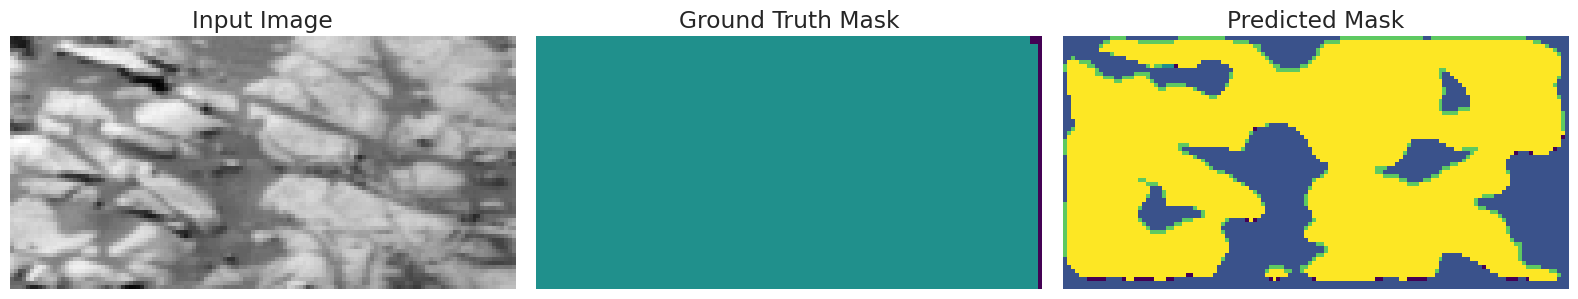

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2813 - loss: 1.4161 - mean_iou: 0.1058 - val_accuracy: 0.2228 - val_loss: 1.5638 - val_mean_iou: 0.0708 - learning_rate: 0.0010
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1448 - loss: 1.5768 - mean_iou: 0.0579 - val_accuracy: 0.1446 - val_loss: 1.9202 - val_mean_iou: 0.0677 - learning_rate: 0.0010
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1398 - loss: 1.5614 - mean_iou: 0.0509 - val_accuracy: 0.1364 - val_loss: 1.7426 - val_mean_iou: 0.0565 - learning_rate: 0.0010
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1178 - loss: 1.5400 - mean_iou: 0.0458 - val_accuracy: 0.0732 - val_loss: 1.7046 - val_mean_iou: 0.0335 - learning_rate: 0.0010
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1237 - loss: 1.5318 - mean_iou: 0.0476 - val_accuracy: 0.1084 - val_loss: 1.7256 - val_mean_iou: 0.0469 - learning_rate: 0.0010
Epoch 21/1000
32/32 ━━━━━━━━━━━━━━━━━━━

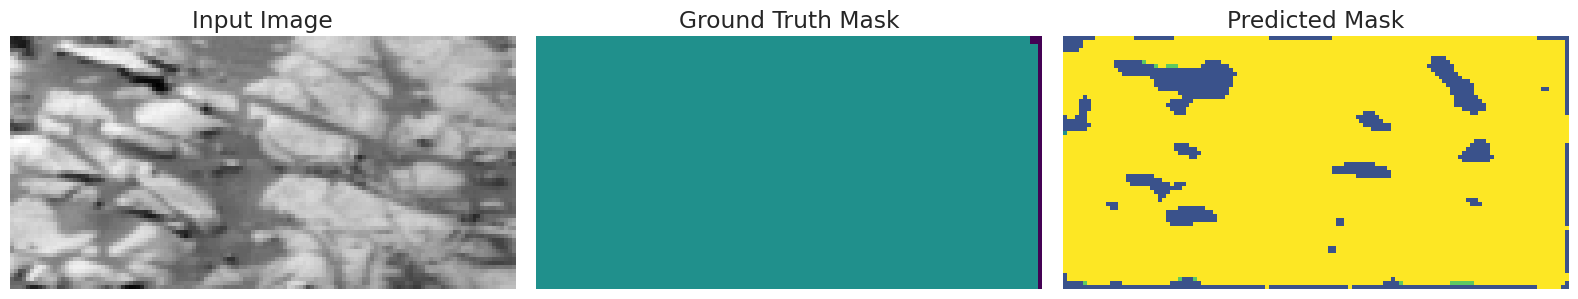

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0949 - loss: 1.5863 - mean_iou: 0.0402 - val_accuracy: 0.1107 - val_loss: 1.6350 - val_mean_iou: 0.0445 - learning_rate: 0.0010
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1032 - loss: 1.5994 - mean_iou: 0.0395 - val_accuracy: 0.0839 - val_loss: 1.5890 - val_mean_iou: 0.0372 - learning_rate: 0.0010
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0886 - loss: 1.5689 - mean_iou: 0.0386 - val_accuracy: 0.0758 - val_loss: 1.6413 - val_mean_iou: 0.0342 - learning_rate: 0.0010
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0963 - loss: 1.5998 - mean_iou: 0.0442 - val_accuracy: 0.1321 - val_loss: 2.4312 - val_mean_iou: 0.0034 - learning_rate: 0.0010
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1139 - loss: 1.6086 - mean_iou: 0.0494 - val_accuracy: 0.0693 - val_loss: 1.6578 - val_mean_iou: 0.0100 - learning_rate: 0.0010
Epoch 26/1000
32/32 ━━━━━━━━━━━━━━━━━━━

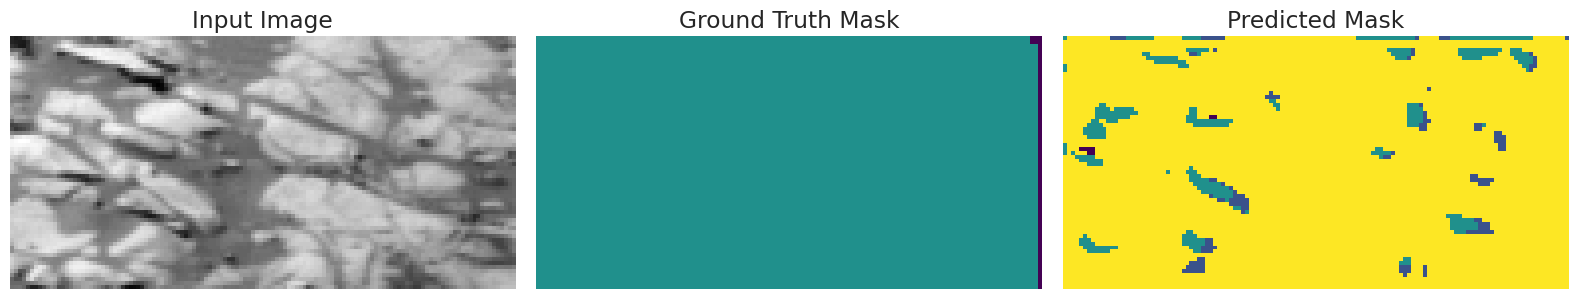

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1120 - loss: 1.5890 - mean_iou: 0.0475 - val_accuracy: 0.0469 - val_loss: 1.6236 - val_mean_iou: 0.0188 - learning_rate: 0.0010
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0739 - loss: 1.6160 - mean_iou: 0.0343 - val_accuracy: 0.0388 - val_loss: 1.6567 - val_mean_iou: 0.0258 - learning_rate: 0.0010
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1137 - loss: 1.6203 - mean_iou: 0.0458 - val_accuracy: 0.0758 - val_loss: 1.6219 - val_mean_iou: 0.0444 - learning_rate: 0.0010
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0941 - loss: 1.6059 - mean_iou: 0.0411 - val_accuracy: 0.2948 - val_loss: 2.0815 - val_mean_iou: 0.0900 - learning_rate: 0.0010
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0739 - loss: 1.6220 - mean_iou: 0.0334 - val_accuracy: 0.2489 - val_loss: 1.9867 - val_mean_iou: 0.0822 - learning_rate: 1.0000e-04
Epoch 31/1000
32/32 ━━━━━━━━━━━━━━━

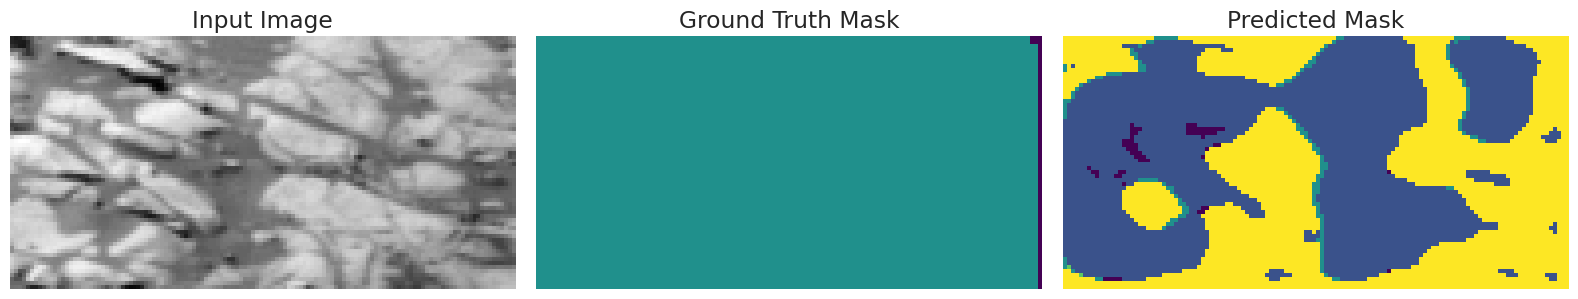

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0440 - loss: 1.6081 - mean_iou: 0.0208 - val_accuracy: 0.1347 - val_loss: 1.6227 - val_mean_iou: 0.0556 - learning_rate: 1.0000e-04
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0444 - loss: 1.6075 - mean_iou: 0.0213 - val_accuracy: 0.1100 - val_loss: 1.6845 - val_mean_iou: 0.0476 - learning_rate: 1.0000e-04
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0482 - loss: 1.6203 - mean_iou: 0.0238 - val_accuracy: 0.0942 - val_loss: 1.9008 - val_mean_iou: 0.0426 - learning_rate: 1.0000e-04
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0484 - loss: 1.6091 - mean_iou: 0.0253 - val_accuracy: 0.0851 - val_loss: 1.8882 - val_mean_iou: 0.0392 - learning_rate: 1.0000e-04
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0456 - loss: 1.6054 - mean_iou: 0.0224 - val_accuracy: 0.0758 - val_loss: 1.8836 - val_mean_iou: 0.0355 - learning_rate: 1.0000e-04
Epoch 36/1000
32/32

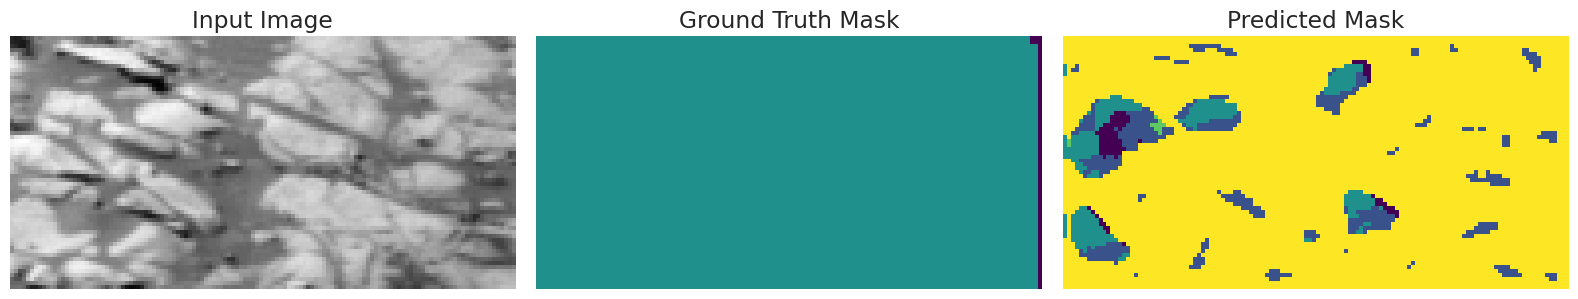

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0486 - loss: 1.6063 - mean_iou: 0.0230 - val_accuracy: 0.0655 - val_loss: 1.6126 - val_mean_iou: 0.0326 - learning_rate: 1.0000e-04
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0412 - loss: 1.6035 - mean_iou: 0.0190 - val_accuracy: 0.0600 - val_loss: 1.6102 - val_mean_iou: 0.0292 - learning_rate: 1.0000e-04
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0432 - loss: 1.6037 - mean_iou: 0.0195 - val_accuracy: 0.0525 - val_loss: 1.6090 - val_mean_iou: 0.0248 - learning_rate: 1.0000e-04
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0431 - loss: 1.6048 - mean_iou: 0.0187 - val_accuracy: 0.0419 - val_loss: 1.6617 - val_mean_iou: 0.0164 - learning_rate: 1.0000e-04
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0599 - loss: 1.6158 - mean_iou: 0.0299 - val_accuracy: 0.0391 - val_loss: 1.6215 - val_mean_iou: 0.0202 - learning_rate: 1.0000e-04
Epoch 41/1000
32/32

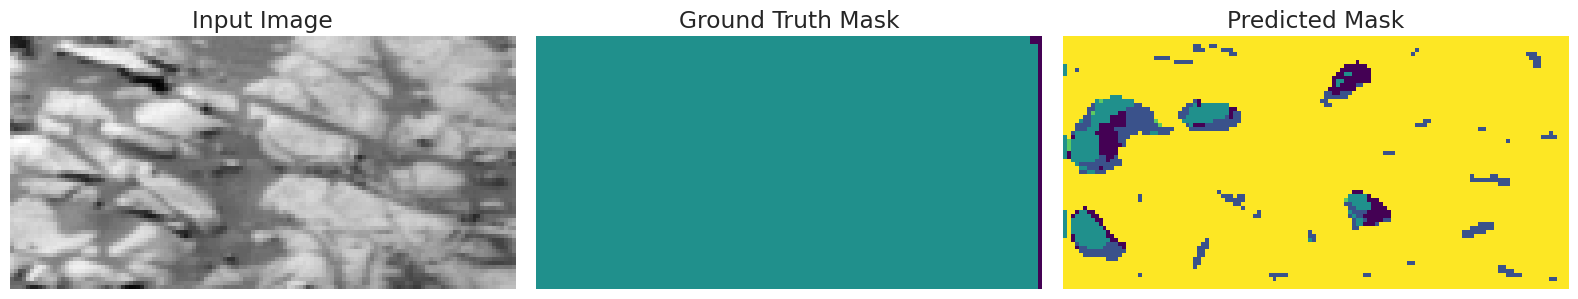

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0462 - loss: 1.6087 - mean_iou: 0.0236 - val_accuracy: 0.0452 - val_loss: 1.6148 - val_mean_iou: 0.0265 - learning_rate: 1.0000e-04
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0518 - loss: 1.6079 - mean_iou: 0.0271 - val_accuracy: 0.0491 - val_loss: 1.6549 - val_mean_iou: 0.0269 - learning_rate: 1.0000e-04
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0593 - loss: 1.6825 - mean_iou: 0.0326 - val_accuracy: 0.0446 - val_loss: 1.6255 - val_mean_iou: 0.0277 - learning_rate: 1.0000e-04
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0466 - loss: 1.6090 - mean_iou: 0.0291 - val_accuracy: 0.0459 - val_loss: 1.6192 - val_mean_iou: 0.0288 - learning_rate: 1.0000e-04
Final validation Mean Intersection Over Union: 14.97%
Model saved to model_241204_111605.keras


In [30]:
# Train the model
history = model.fit( #batch size already defined in definition of data loader
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, learning_rate],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file 
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

del model

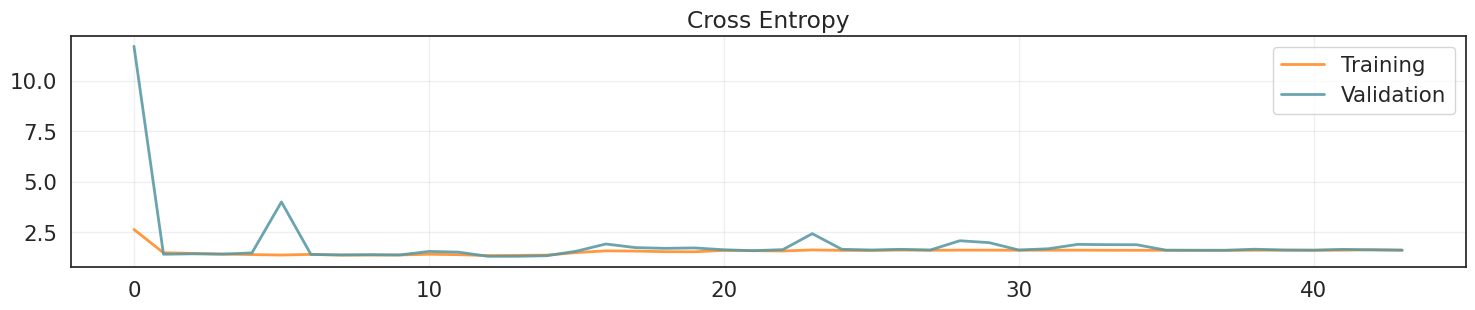

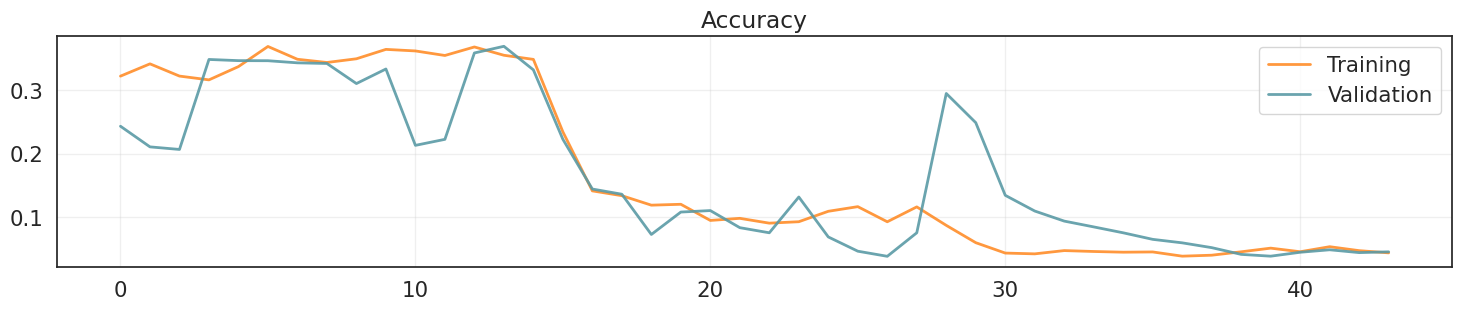

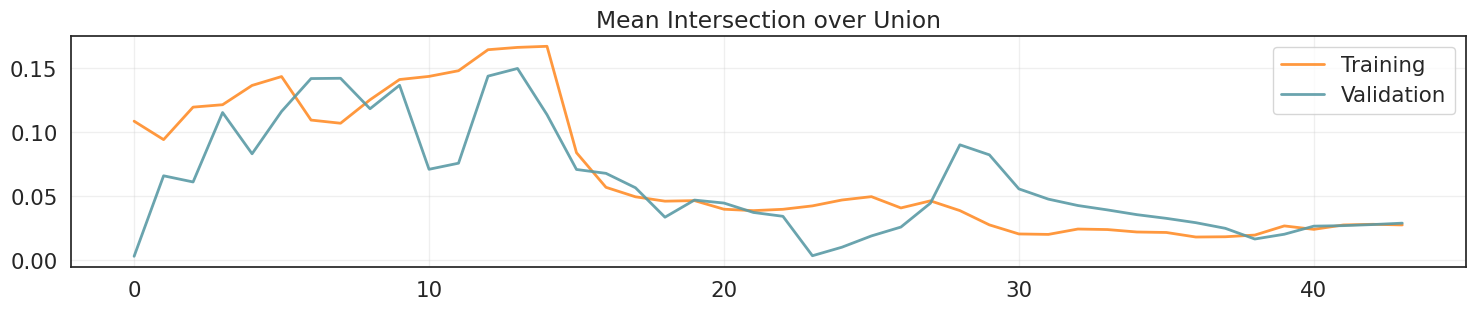

In [31]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [32]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [33]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241204_111605.keras


In [34]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 98s 257ms/step
Predictions shape: (10022, 64, 128)


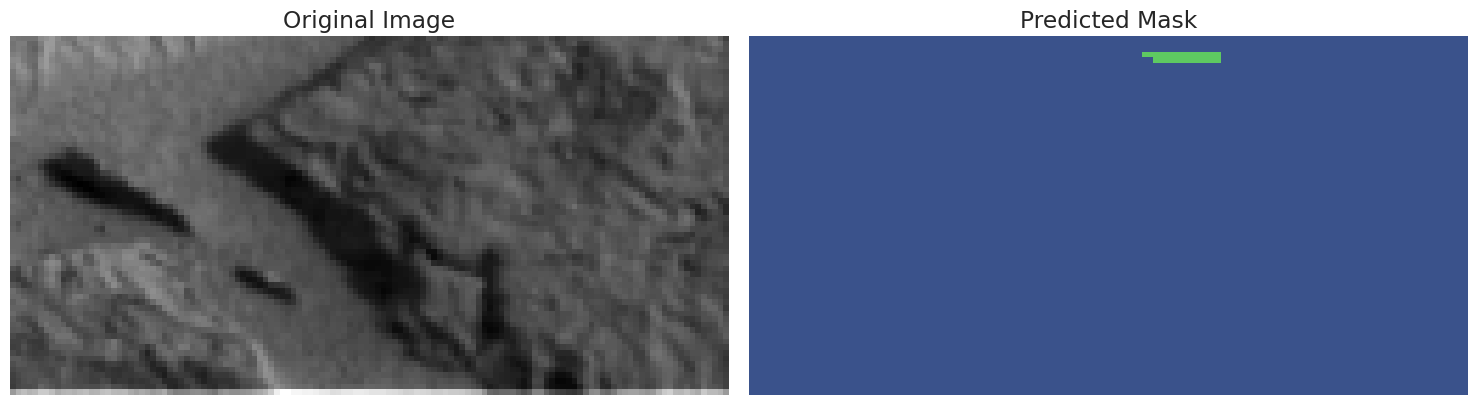

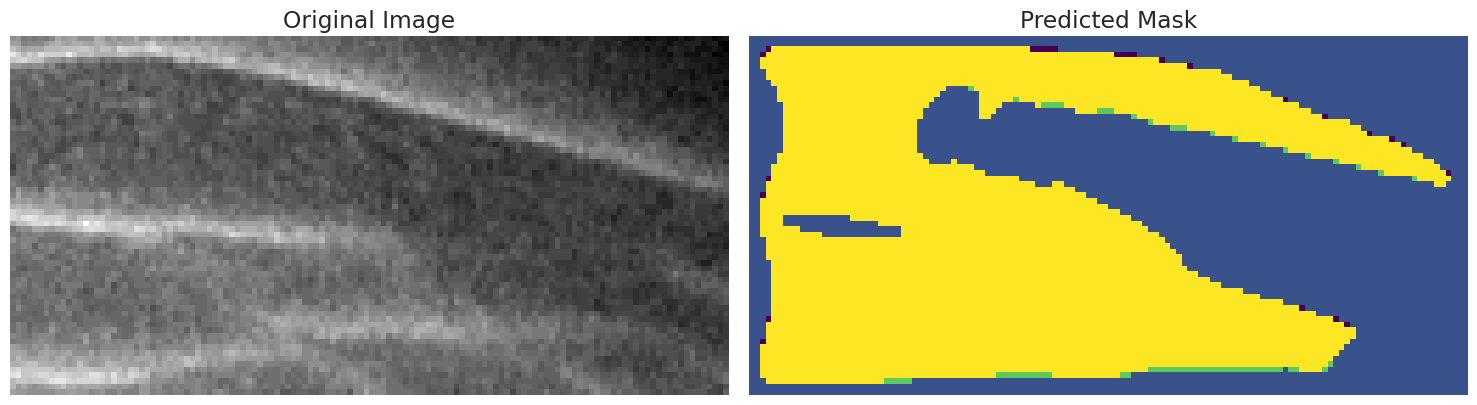

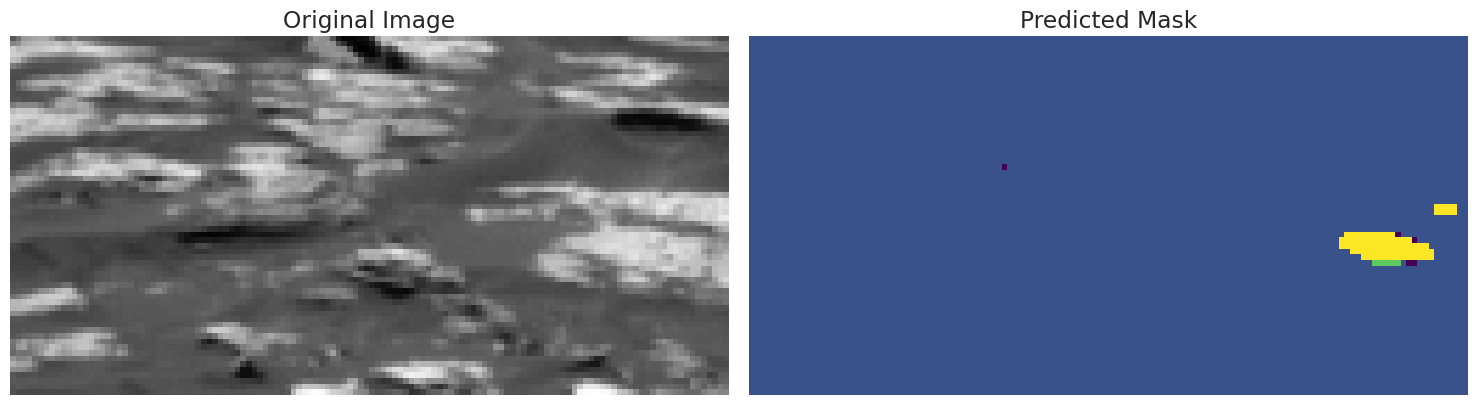

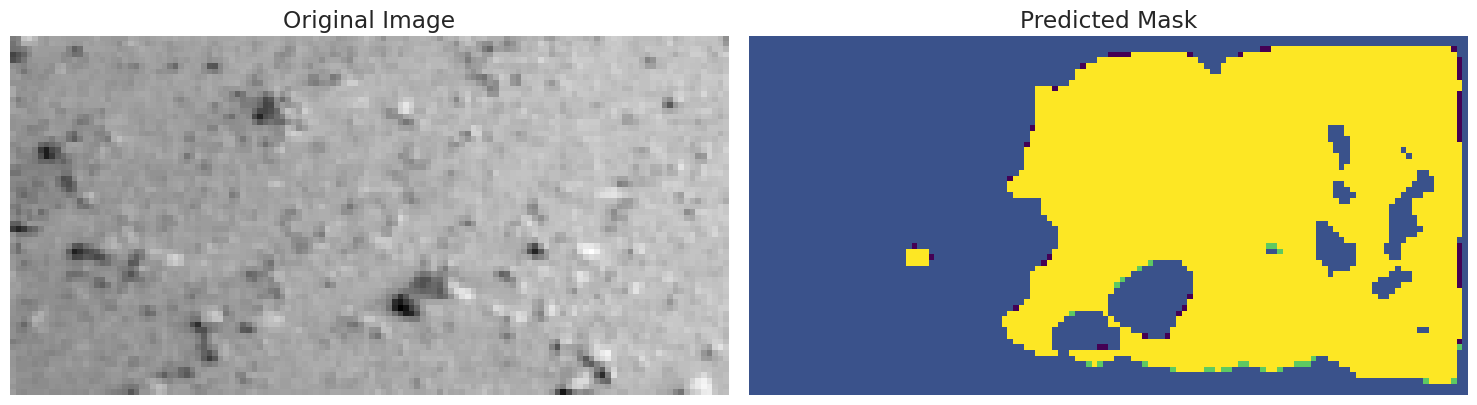

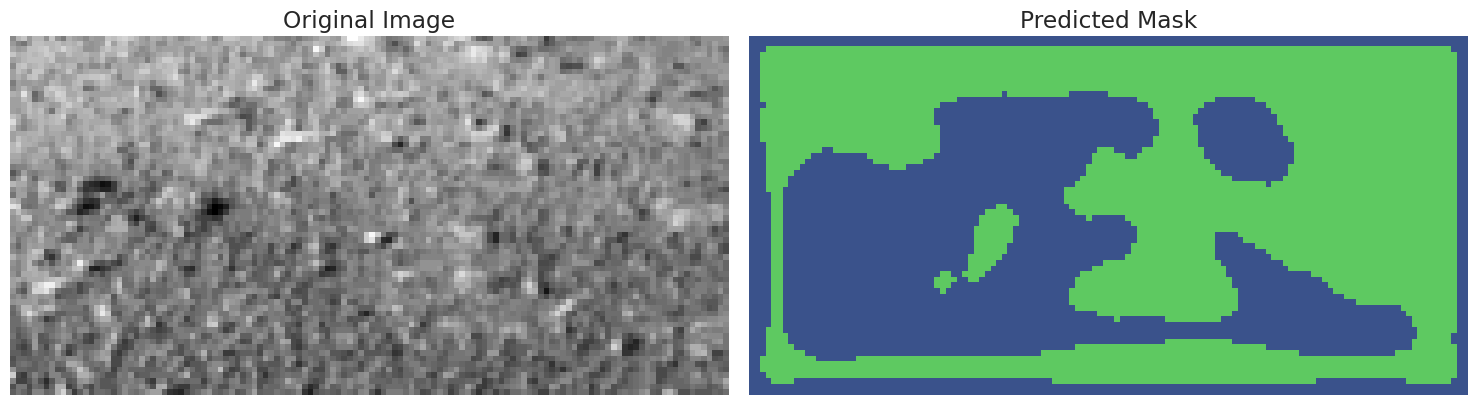

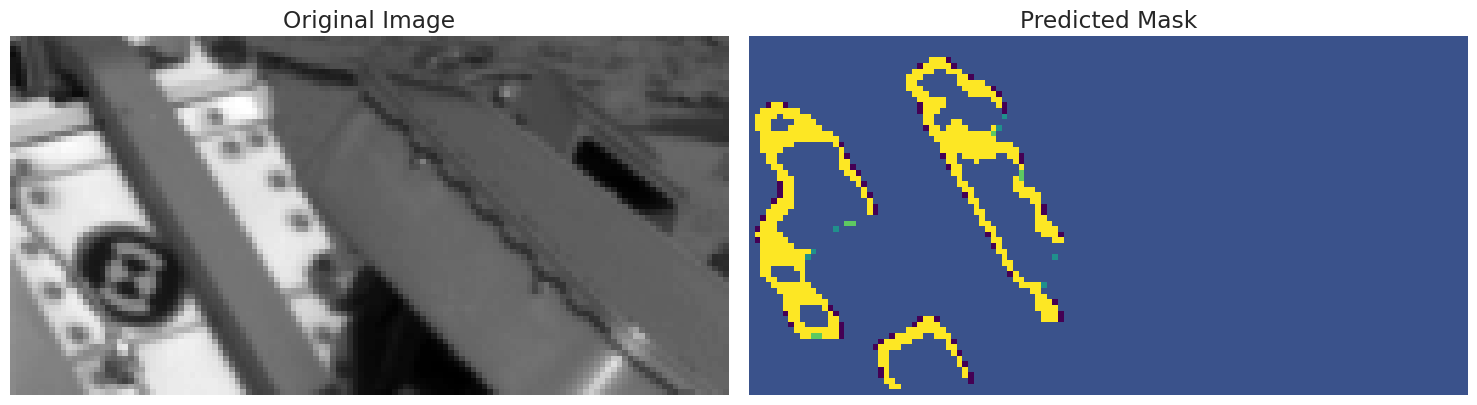

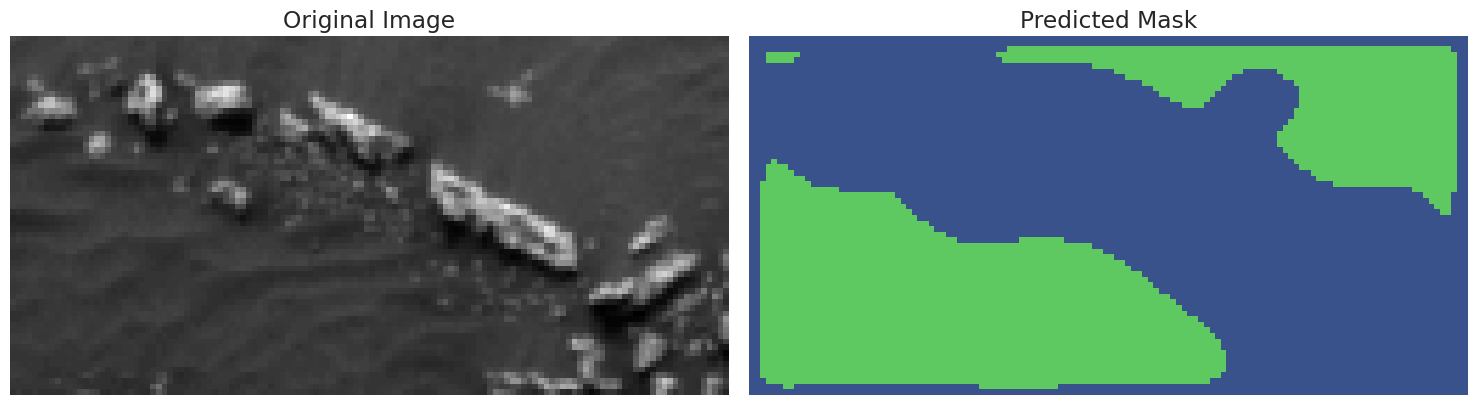

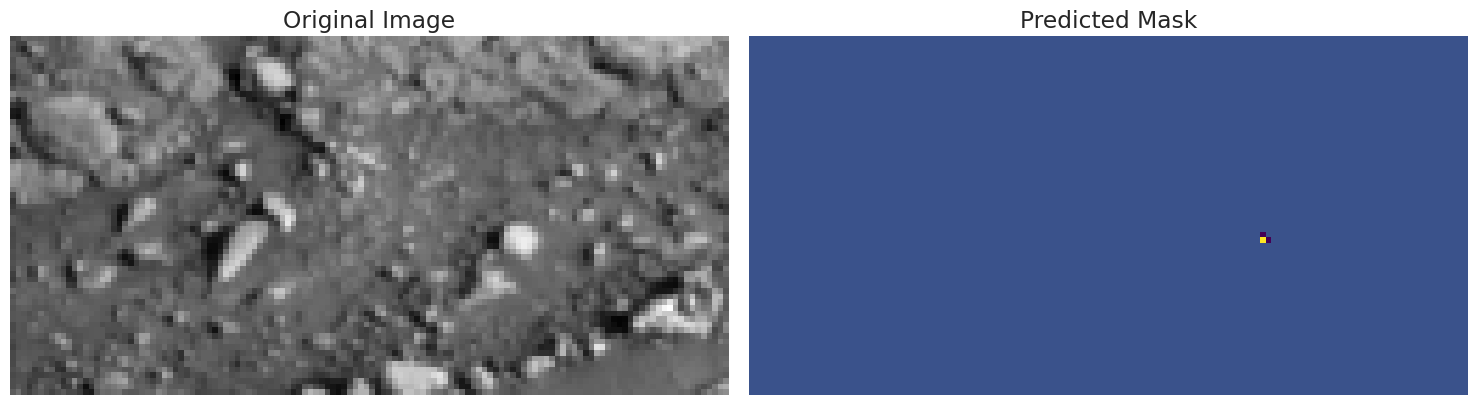

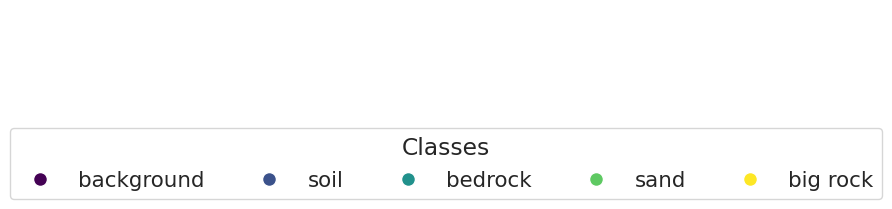

In [35]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

## 📊 Prepare the Submission

In [36]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)